In [52]:
import numpy as np
import pandas as pd
import os
import psutil
import yaml
import time
import csv
import random
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import scipy.signal as signal
from scipy.signal import butter, filtfilt, sosfilt
from scipy import ndimage

from pywt import wavedec, waverec, threshold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchsummary import summary

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, train_test_split

from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.util import random_noise

In [53]:
# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [54]:
# Helper functions for data loading
def map_seismic_to_velocity_path(input_file):
    """Convert seismic data path to velocity model path"""
    return Path(str(input_file).replace('seis', 'vel').replace('data', 'model'))

def get_train_files(data_path):
    """Find all seismic data files and map to velocity model files"""
    # Find all seismic data files (containing 'seis' or 'data' in filename)
    input_files = [
        f for f in Path(data_path).rglob('*.npy')
        if ('seis' in f.stem) or ('data' in f.stem)
    ]
    
    # Map each input file to its corresponding output file
    output_files = [map_seismic_to_velocity_path(f) for f in input_files]
    
    # Verify all output files exist
    missing_files = [f for f in output_files if not f.exists()]
    if missing_files:
        raise FileNotFoundError(f"Missing velocity model files: {missing_files[:5]}...")
    
    return input_files, output_files

# Data Analysis

## Pooling Classes

In [55]:
# Define pooling classes in the global scope so they can be used by multiple functions
class ChannelAwarePool(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        # Different pooling strategies for different channel characteristics
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=kernel_size, stride=stride)
        self.max_pool = torch.nn.MaxPool2d(kernel_size=kernel_size, stride=stride)
        
    def forward(self, x):
        batch_size, channels, height, width = x.shape
        result = torch.zeros(batch_size, channels, height // self.kernel_size[0], width, 
                            device=x.device, dtype=x.dtype)
        
        for c in range(channels):
            channel_data = x[:, c:c+1]
            
            # Analyze channel statistics to determine best pooling method
            channel_std = torch.std(channel_data)
            channel_mean = torch.mean(channel_data)
            sparsity = torch.sum(torch.abs(channel_data) > 0.1 * torch.max(torch.abs(channel_data))) / torch.numel(channel_data)
            
            # Choose pooling method based on channel characteristics
            if sparsity < 0.3:  # Sparse data - preserve peaks with max pooling
                result[:, c:c+1] = self.max_pool(channel_data)
            else:  # Dense data - use average pooling
                result[:, c:c+1] = self.avg_pool(channel_data)
                
        return result

class WaveletPool(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        
    def forward(self, x):
        batch_size, channels, height, width = x.shape
        target_height = height // self.stride[0]
        result = torch.zeros(batch_size, channels, target_height, width,
                           device=x.device, dtype=x.dtype)
        
        # Process each channel independently
        for b in range(batch_size):
            for c in range(channels):
                # Process each column independently
                for w in range(width):
                    col_data = x[b, c, :, w].cpu().numpy()
                    
                    # Simple approximation of wavelet decomposition 
                    # by taking the average of groups while preserving strong features
                    for i in range(target_height):
                        start_idx = i * self.stride[0]
                        end_idx = min(start_idx + self.kernel_size[0], height)
                        segment = col_data[start_idx:end_idx]
                        
                        # Preserve dominant features in the segment
                        abs_segment = np.abs(segment)
                        if np.max(abs_segment) > 2.0 * np.mean(abs_segment):
                            # If strong features exist, use max value with sign preservation
                            max_idx = np.argmax(abs_segment)
                            result[b, c, i, w] = torch.tensor(segment[max_idx], device=x.device)
                        else:
                            # Otherwise use average
                            result[b, c, i, w] = torch.tensor(np.mean(segment), device=x.device)
        
        return result

## Data Analysis Functions

In [56]:
# Data analysis functions
def analyze_dataset_statistics(input_files, output_files, n_samples=10):
    """Analyze basic statistics of the dataset"""
    input_stats = []
    output_stats = []
    
    # Sample files for analysis
    sample_indices = random.sample(range(len(input_files)), min(n_samples, len(input_files)))
    
    for idx in tqdm(sample_indices, desc="Analyzing files"):
        input_data = np.load(input_files[idx])
        output_data = np.load(output_files[idx])
        
        # Print shapes to understand data structure
        print(f"Input data shape: {input_data.shape}")
        print(f"Output data shape: {output_data.shape}")
        
        # Collect statistics for input data
        input_stats.append({
            'file': input_files[idx].name,
            'shape': input_data.shape,
            'min': np.min(input_data),
            'max': np.max(input_data),
            'mean': np.mean(input_data),
            'median': np.median(input_data),
            'std': np.std(input_data),
            'skew': stats.skew(input_data.reshape(-1)),
            'kurtosis': stats.kurtosis(input_data.reshape(-1)),
            'zeros_pct': np.mean(input_data == 0) * 100,
            'unique_values': len(np.unique(input_data)),
        })
        
        # Collect statistics for output data
        output_stats.append({
            'file': output_files[idx].name,
            'shape': output_data.shape,
            'min': np.min(output_data),
            'max': np.max(output_data),
            'mean': np.mean(output_data),
            'median': np.median(output_data),
            'std': np.std(output_data),
            'skew': stats.skew(output_data.reshape(-1)),
            'kurtosis': stats.kurtosis(output_data.reshape(-1)),
            'zeros_pct': np.mean(output_data == 0) * 100,
            'unique_values': len(np.unique(output_data)),
        })
    
    input_df = pd.DataFrame(input_stats)
    output_df = pd.DataFrame(output_stats)
    
    print("\n=== INPUT DATA STATISTICS ===")
    print(input_df[['min', 'max', 'mean', 'median', 'std', 'zeros_pct']].describe())
    
    print("\n=== OUTPUT DATA STATISTICS ===")
    print(output_df[['min', 'max', 'mean', 'median', 'std', 'zeros_pct']].describe())
    
    return input_df, output_df, input_data.shape, output_data.shape

def visualize_sample_pair(input_file, output_file, index=0, sample_idx=0, channel_idx=0, figsize=(15, 10)):
    """Visualize a sample pair of input seismic data and output velocity model"""
    input_data = np.load(input_file)
    output_data = np.load(output_file)
    
    print(f"Input data shape: {input_data.shape}")
    print(f"Output data shape: {output_data.shape}")
    
    # Based on your data structure: [samples, channels, height, width]
    # Select a specific sample and channel
    seismic_sample = input_data[sample_idx, channel_idx]
    velocity_sample = output_data[sample_idx, 0]  # Assuming output has 1 channel
    
    print(f"Seismic sample shape: {seismic_sample.shape}")
    print(f"Velocity sample shape: {velocity_sample.shape}")
    
    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    # Plot seismic data
    im0 = axs[0, 0].imshow(seismic_sample, aspect='auto', cmap='seismic')
    axs[0, 0].set_title(f'Seismic Data - Sample {sample_idx}, Channel {channel_idx}')
    axs[0, 0].set_xlabel('X position')
    axs[0, 0].set_ylabel('Time/Depth')
    plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
    # Plot velocity model
    im1 = axs[0, 1].imshow(velocity_sample, aspect='auto', cmap='viridis')
    axs[0, 1].set_title(f'Velocity Model - Sample {sample_idx}')
    axs[0, 1].set_xlabel('X position')
    axs[0, 1].set_ylabel('Depth')
    plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
    # Plot histograms
    axs[1, 0].hist(seismic_sample.ravel(), bins=50, alpha=0.7, color='blue')
    axs[1, 0].set_title('Seismic Data Histogram')
    axs[1, 0].set_xlabel('Amplitude')
    axs[1, 0].set_ylabel('Frequency')
    
    axs[1, 1].hist(velocity_sample.ravel(), bins=50, alpha=0.7, color='green')
    axs[1, 1].set_title('Velocity Model Histogram')
    axs[1, 1].set_xlabel('Velocity (m/s)')
    axs[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(f'output/{sample_idx}_visualize_sample_pair_channel{channel_idx}.png')
    plt.show()
    
    return seismic_sample, velocity_sample

def visualize_channels(input_file, sample_idx=0, figsize=(20, 15)):
    """Visualize all channels of a seismic data sample"""
    input_data = np.load(input_file)
    
    # Select a specific sample
    if len(input_data.shape) == 4:  # [samples, channels, height, width]
        sample_data = input_data[sample_idx]
        n_channels = sample_data.shape[0]
    else:
        raise ValueError(f"Unexpected data shape: {input_data.shape}")
    
    # Create a grid of subplots - 2 rows with 3 columns should be enough for 5 channels
    fig, axs = plt.subplots(2, 3, figsize=figsize)
    
    # Flatten the axes array for easier indexing
    axs = axs.flatten()
    
    # Plot each channel
    for i in range(n_channels):
        channel_data = sample_data[i]
        
        im = axs[i].imshow(channel_data, aspect='auto', cmap='seismic')
        axs[i].set_title(f'Channel {i} - Shape: {channel_data.shape}')
        axs[i].set_xlabel('X position')
        axs[i].set_ylabel('Time/Depth')
        plt.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
    
    # Hide any unused subplots
    for i in range(n_channels, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'output/{sample_idx}_visualize_channels.png')
    plt.show()
    
    return sample_data

def analyze_spectral_content(input_file, output_file, sample_idx=0, channel_idx=0, figsize=(15, 10)):
    """Analyze the spectral content of input and output data"""
    input_data = np.load(input_file)
    output_data = np.load(output_file)
    
    # Select data based on known shape
    seismic_sample = input_data[sample_idx, channel_idx]
    velocity_sample = output_data[sample_idx, 0]  # Assuming output has 1 channel
    
    # Compute 2D FFT
    seismic_fft = np.fft.fft2(seismic_sample)
    seismic_fft_shifted = np.fft.fftshift(seismic_fft)
    seismic_magnitude = np.log1p(np.abs(seismic_fft_shifted))
    
    velocity_fft = np.fft.fft2(velocity_sample)
    velocity_fft_shifted = np.fft.fftshift(velocity_fft)
    velocity_magnitude = np.log1p(np.abs(velocity_fft_shifted))
    
    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    # Plot original data
    im0 = axs[0, 0].imshow(seismic_sample, aspect='auto', cmap='seismic')
    axs[0, 0].set_title(f'Seismic Data - Sample {sample_idx}, Channel {channel_idx}')
    plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
    im1 = axs[0, 1].imshow(velocity_sample, aspect='auto', cmap='viridis')
    axs[0, 1].set_title(f'Velocity Model - Sample {sample_idx}')
    plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
    # Plot FFT magnitude
    im2 = axs[1, 0].imshow(seismic_magnitude, aspect='auto', cmap='inferno')
    axs[1, 0].set_title('Seismic Data FFT Magnitude (log scale)')
    plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)
    
    im3 = axs[1, 1].imshow(velocity_magnitude, aspect='auto', cmap='inferno')
    axs[1, 1].set_title('Velocity Model FFT Magnitude (log scale)')
    plt.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig(f'output/{sample_idx}_spectral_content_channel{channel_idx}.png')
    plt.show()
    
    return seismic_magnitude, velocity_magnitude

def analyze_gradient_patterns(input_file, output_file, sample_idx=0, channel_idx=0, figsize=(15, 15)):
    """
    Analyze gradient patterns in the data
    """
    input_data = np.load(input_file)
    output_data = np.load(output_file)
    
    # Select data based on known shape
    seismic_sample = input_data[sample_idx, channel_idx]  # Shape: [1000, 70]
    velocity_sample = output_data[sample_idx, 0]         # Shape: [70, 70]
    
    print(f"Seismic sample shape: {seismic_sample.shape}")
    print(f"Velocity sample shape: {velocity_sample.shape}")
    
    # Compute gradients
    seismic_grad_y, seismic_grad_x = np.gradient(seismic_sample)
    velocity_grad_y, velocity_grad_x = np.gradient(velocity_sample)
    
    # Compute gradient magnitude
    seismic_grad_mag = np.sqrt(seismic_grad_x**2 + seismic_grad_y**2)
    velocity_grad_mag = np.sqrt(velocity_grad_x**2 + velocity_grad_y**2)
    
    # Create figure
    fig, axs = plt.subplots(3, 3, figsize=figsize)
    
    # Plot original data
    im0 = axs[0, 0].imshow(seismic_sample, aspect='auto', cmap='seismic')
    axs[0, 0].set_title(f'Seismic Data - Sample {sample_idx}, Channel {channel_idx}')
    plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
    im1 = axs[0, 1].imshow(velocity_sample, aspect='auto', cmap='viridis')
    axs[0, 1].set_title(f'Velocity Model - Sample {sample_idx}')
    plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
    # Plot x-gradients
    im2 = axs[1, 0].imshow(seismic_grad_x, aspect='auto', cmap='coolwarm')
    axs[1, 0].set_title('Seismic X-Gradient')
    plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)
    
    im3 = axs[1, 1].imshow(velocity_grad_x, aspect='auto', cmap='coolwarm')
    axs[1, 1].set_title('Velocity X-Gradient')
    plt.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)
    
    # Instead of scatter plots (which require same sizes), show histogram of gradients
    axs[1, 2].hist(seismic_grad_x.flatten(), bins=50, alpha=0.5, label='Seismic')
    axs[1, 2].hist(velocity_grad_x.flatten(), bins=50, alpha=0.5, label='Velocity')
    axs[1, 2].set_title('X-Gradient Histograms')
    axs[1, 2].set_xlabel('Gradient Value')
    axs[1, 2].set_ylabel('Frequency')
    axs[1, 2].legend()
    
    # Plot y-gradients
    im4 = axs[2, 0].imshow(seismic_grad_y, aspect='auto', cmap='coolwarm')
    axs[2, 0].set_title('Seismic Y-Gradient')
    plt.colorbar(im4, ax=axs[2, 0], fraction=0.046, pad=0.04)
    
    im5 = axs[2, 1].imshow(velocity_grad_y, aspect='auto', cmap='coolwarm')
    axs[2, 1].set_title('Velocity Y-Gradient')
    plt.colorbar(im5, ax=axs[2, 1], fraction=0.046, pad=0.04)
    
    # Y-gradient histograms instead of scatter
    axs[2, 2].hist(seismic_grad_y.flatten(), bins=50, alpha=0.5, label='Seismic')
    axs[2, 2].hist(velocity_grad_y.flatten(), bins=50, alpha=0.5, label='Velocity')
    axs[2, 2].set_title('Y-Gradient Histograms')
    axs[2, 2].set_xlabel('Gradient Value')
    axs[2, 2].set_ylabel('Frequency')
    axs[2, 2].legend()
    
    # Plot gradient magnitude
    im6 = axs[0, 2].imshow(np.log1p(seismic_grad_mag), aspect='auto', cmap='inferno')
    axs[0, 2].set_title('Seismic Gradient Magnitude (log scale)')
    plt.colorbar(im6, ax=axs[0, 2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig(f'output/{sample_idx}_gradient_patterns_channel{channel_idx}.png')
    plt.show()
    
    # return mean gradient values
    return np.mean(seismic_grad_mag), np.mean(velocity_grad_mag)

def analyze_pooling_alternatives(input_file, sample_idx=0, compare_methods=True):
    """
    Analyze alternatives to AvgPool2d that better preserve information in seismic data.
    
    Args:
        input_file: Path to input .npy file containing seismic data
        sample_idx: Index of the sample to analyze
        compare_methods: Whether to compare multiple pooling methods
        
    Returns:
        Dictionary containing original and pooled data for each method
    """
    input_data = np.load(input_file)
    
    # Get full sample with all channels
    seismic_sample = input_data[sample_idx]
    num_channels = seismic_sample.shape[0]
    original_height = seismic_sample.shape[1]
    original_width = seismic_sample.shape[2]
    
    # Convert to torch tensor for processing (add batch dimension)
    seismic_tensor = torch.from_numpy(seismic_sample).float().unsqueeze(0)
    
    # Standard methods to compare
    methods = {
        'AvgPool': torch.nn.AvgPool2d(kernel_size=(14, 1), stride=(14, 1)),
        'MaxPool': torch.nn.MaxPool2d(kernel_size=(14, 1), stride=(14, 1)),
        'ChannelAwarePool': ChannelAwarePool(kernel_size=(14, 1), stride=(14, 1)),
        'WaveletPool': WaveletPool(kernel_size=(14, 1), stride=(14, 1))
    }
    
    # Apply pooling methods
    results = {'original': seismic_sample}  # Already a numpy array
    for name, pool_method in methods.items():
        pooled_tensor = pool_method(seismic_tensor)
        results[name] = pooled_tensor.squeeze(0).detach().cpu().numpy()
    
    # Visualize comparison if requested
    if compare_methods:
        # Determine number of channels and methods to display
        n_channels = min(3, num_channels)  # Display up to 3 channels
        n_methods = len(methods) + 1  # Original + all methods
        
        fig, axes = plt.subplots(n_channels, n_methods, figsize=(n_methods*4, n_channels*3))
        
        # Use the same color scale for all plots
        vmin = np.min(seismic_sample)
        vmax = np.max(seismic_sample)
        
        # For each channel
        for c in range(n_channels):
            # Plot original data
            if n_channels > 1 and n_methods > 1:
                ax = axes[c, 0]
            elif n_channels > 1:
                ax = axes[c]
            elif n_methods > 1:
                ax = axes[0]
            else:
                ax = axes
                
            im = ax.imshow(seismic_sample[c], aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
            ax.set_title(f'Original Ch {c}')
            ax.set_ylabel('Time/Depth')
            if c == n_channels-1:
                ax.set_xlabel('X position')
            
            # Plot each pooling method
            method_idx = 1  # Start with index 1 (after original)
            for method_name, pooled_data in results.items():
                if method_name == 'original':
                    continue
                    
                if n_channels > 1 and n_methods > 1:
                    ax = axes[c, method_idx]
                elif n_channels > 1:
                    ax = axes[c]
                elif n_methods > 1:
                    ax = axes[method_idx]
                else:
                    ax = axes
                    
                im = ax.imshow(pooled_data[c], aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
                ax.set_title(f'{method_name} Ch {c}')
                if c == n_channels-1:
                    ax.set_xlabel('X position')
                
                method_idx += 1
        
        plt.tight_layout()
        plt.savefig(f'output/{sample_idx}_pooling_comparison.png')
        plt.show()
        
        # Create visualization of information preservation
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Calculate information preservation metrics for each method
        info_metrics = {}
        for method_name, pooled_data in results.items():
            if method_name == 'original':
                continue
                
            # Upsample pooled data to original size for comparison
            upsampled = []
            for c in range(num_channels):
                channel_pooled = pooled_data[c]
                # Calculate exact upsampling factor to match original size
                pooled_height = channel_pooled.shape[0]
                repeat_factor = original_height // pooled_height
                remainder = original_height % pooled_height
                
                # Use repeat for integer upsampling
                channel_upsampled = np.repeat(channel_pooled, repeat_factor, axis=0)
                
                # Handle remainder by duplicating the last few rows if needed
                if remainder > 0:
                    extra_rows = channel_pooled[:remainder]
                    channel_upsampled = np.vstack([channel_upsampled, extra_rows])
                
                # Ensure exact shape match
                channel_upsampled = channel_upsampled[:original_height, :original_width]
                upsampled.append(channel_upsampled)
            
            upsampled_data = np.stack(upsampled)
            
            # Verify shapes match before comparison
            assert upsampled_data.shape == seismic_sample.shape, f"Shape mismatch: {upsampled_data.shape} vs {seismic_sample.shape}"
            
            # Calculate metrics
            mse = np.mean((seismic_sample - upsampled_data) ** 2)
            psnr = 10 * np.log10((np.max(seismic_sample) ** 2) / mse) if mse > 0 else float('inf')
            
            # Calculate frequency domain preservation (simple FFT-based metric)
            freq_preservation = 0
            for c in range(num_channels):
                orig_fft = np.abs(np.fft.fft2(seismic_sample[c]))
                ups_fft = np.abs(np.fft.fft2(upsampled_data[c]))
                
                # Calculate frequency content preservation (higher is better)
                freq_preservation += np.sum(np.minimum(ups_fft, orig_fft)) / np.sum(orig_fft)
            freq_preservation /= num_channels
            
            info_metrics[method_name] = {
                'MSE': mse,
                'PSNR': psnr,
                'FreqPreservation': freq_preservation
            }
        
        # Plot metrics
        methods = list(info_metrics.keys())
        x = np.arange(len(methods))
        width = 0.25
        
        # Normalize metrics for visualization
        psnr_vals = [info_metrics[m]['PSNR'] for m in methods]
        max_psnr = max(psnr_vals) if psnr_vals else 1
        norm_psnr = [p/max_psnr for p in psnr_vals]
        
        freq_vals = [info_metrics[m]['FreqPreservation'] for m in methods]
        
        # Invert MSE for visualization (lower is better)
        mse_vals = [info_metrics[m]['MSE'] for m in methods]
        max_mse = max(mse_vals) if mse_vals else 1
        inv_norm_mse = [1 - (m/max_mse) for m in mse_vals]
        
        ax.bar(x - width, norm_psnr, width, label='PSNR (normalized)')
        ax.bar(x, freq_vals, width, label='Frequency Preservation')
        ax.bar(x + width, inv_norm_mse, width, label='1 - MSE (normalized)')
        
        ax.set_ylabel('Metric Value (higher is better)')
        ax.set_title('Information Preservation by Pooling Method')
        ax.set_xticks(x)
        ax.set_xticklabels(methods)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(f'output/{sample_idx}_pooling_metrics.png')
        plt.show()
        
        # Print summary of findings
        print("\n=== POOLING METHOD COMPARISON ===")
        print(f"Original data shape: {seismic_sample.shape}")
        for method_name, pooled_data in results.items():
            if method_name == 'original':
                continue
            print(f"{method_name} shape: {pooled_data.shape}")
            if method_name in info_metrics:
                print(f"  - MSE: {info_metrics[method_name]['MSE']:.4f}")
                print(f"  - PSNR: {info_metrics[method_name]['PSNR']:.2f} dB")
                print(f"  - Frequency Preservation: {info_metrics[method_name]['FreqPreservation']:.4f}")
        
        # Determine best method based on combined metrics
        combined_scores = {}
        for method, metrics in info_metrics.items():
            # Normalize and combine metrics (equal weighting)
            norm_psnr = metrics['PSNR'] / max_psnr if max_psnr > 0 else 0
            norm_freq = metrics['FreqPreservation']
            norm_mse = 1 - (metrics['MSE'] / max_mse) if max_mse > 0 else 0
            
            combined_scores[method] = (norm_psnr + norm_freq + norm_mse) / 3
        
        best_method = max(combined_scores, key=combined_scores.get) if combined_scores else None
        if best_method:
            print(f"\nRecommended pooling method: {best_method}")
            print(f"Combined score: {combined_scores[best_method]:.4f}")
        
    return results, info_metrics if compare_methods else results

# Update the original function to maintain backward compatibility
def analyze_initial_pool_effect(input_file, sample_idx=0, channel_idx=0):
    """Analyze the effect of the initial pooling layer in the UNet model"""
    input_data = np.load(input_file)
    
    # Select a specific sample and channel
    seismic_sample = input_data[sample_idx, channel_idx]
    
    # Convert to torch tensor for processing (add batch and channel dimensions)
    seismic_tensor = torch.from_numpy(seismic_sample).float().unsqueeze(0).unsqueeze(0)
    
    # Apply the initial_pool operation
    pool = torch.nn.AvgPool2d(kernel_size=(14, 1), stride=(14, 1))
    pooled_tensor = pool(seismic_tensor)
    
    # Convert back to numpy for visualization
    seismic_np = seismic_sample
    pooled_np = pooled_tensor.squeeze().detach().cpu().numpy()
    
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot original data
    im0 = axs[0].imshow(seismic_np, aspect='auto', cmap='seismic')
    axs[0].set_title(f'Original Seismic Data - Sample {sample_idx}, Channel {channel_idx}')
    axs[0].set_xlabel('X position')
    axs[0].set_ylabel('Time/Depth')
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    
    # Plot pooled data
    im1 = axs[1].imshow(pooled_np, aspect='auto', cmap='seismic')
    axs[1].set_title(f'After AvgPool2d(14,1) - Shape: {pooled_np.shape}')
    axs[1].set_xlabel('X position')
    axs[1].set_ylabel('Time/Depth (reduced)')
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig(f'output/{sample_idx}_initial_pool_effect_channel{channel_idx}.png')
    plt.show()
    
    # Important: Return only the expected values to maintain compatibility with existing code
    return seismic_np, pooled_np

# New function that extends the original but shows the improved method too
def analyze_improved_pooling(input_file, sample_idx=0, channel_idx=0):
    """Compare the effect of different pooling methods on seismic data"""
    input_data = np.load(input_file)
    
    # Select a specific sample and channel
    seismic_sample = input_data[sample_idx, channel_idx]
    
    # Convert to torch tensor for processing (add batch and channel dimensions)
    seismic_tensor = torch.from_numpy(seismic_sample).float().unsqueeze(0).unsqueeze(0)
    
    # Apply different pooling operations
    avg_pool = torch.nn.AvgPool2d(kernel_size=(14, 1), stride=(14, 1))
    avg_pooled_tensor = avg_pool(seismic_tensor)
    
    # Use the improved method (WaveletPool)
    wavelet_pool = WaveletPool(kernel_size=(14, 1), stride=(14, 1))
    wavelet_pooled_tensor = wavelet_pool(seismic_tensor)
    
    # Convert back to numpy for visualization
    seismic_np = seismic_sample
    avg_pooled_np = avg_pooled_tensor.squeeze().detach().cpu().numpy()
    wavelet_pooled_np = wavelet_pooled_tensor.squeeze().detach().cpu().numpy()
    
    # Create figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot original data
    im0 = axs[0].imshow(seismic_np, aspect='auto', cmap='seismic')
    axs[0].set_title(f'Original Seismic Data - Sample {sample_idx}, Channel {channel_idx}')
    axs[0].set_xlabel('X position')
    axs[0].set_ylabel('Time/Depth')
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    
    # Plot standard pooled data
    im1 = axs[1].imshow(avg_pooled_np, aspect='auto', cmap='seismic')
    axs[1].set_title(f'After AvgPool2d(14,1)')
    axs[1].set_xlabel('X position')
    axs[1].set_ylabel('Time/Depth (reduced)')
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    
    # Plot improved pooled data
    im2 = axs[2].imshow(wavelet_pooled_np, aspect='auto', cmap='seismic')
    axs[2].set_title(f'After WaveletPool(14,1)')
    axs[2].set_xlabel('X position')
    axs[2].set_ylabel('Time/Depth (reduced)')
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig(f'output/{sample_idx}_comparison_pool_channel{channel_idx}.png')
    plt.show()
    
    return seismic_np, avg_pooled_np, wavelet_pooled_np

def analyze_frequency_components(input_file, output_file, sample_idx=0, channel_idx=0, figsize=(15, 10)):
    """Analyze and compare frequency components between input and output data"""
    input_data = np.load(input_file)
    output_data = np.load(output_file)
    
    # Select data based on known shape
    seismic_sample = input_data[sample_idx, channel_idx]
    velocity_sample = output_data[sample_idx, 0]  # Assuming output has 1 channel
    
    # Compute frequency content
    # For seismic data - average across spatial dimension
    seismic_fft_rows = np.fft.rfft(seismic_sample, axis=0)
    seismic_fft_cols = np.fft.rfft(seismic_sample, axis=1)
    
    seismic_power_rows = np.mean(np.abs(seismic_fft_rows)**2, axis=1)
    seismic_power_cols = np.mean(np.abs(seismic_fft_cols)**2, axis=0)
    
    # For velocity data
    velocity_fft_rows = np.fft.rfft(velocity_sample, axis=0)
    velocity_fft_cols = np.fft.rfft(velocity_sample, axis=1)
    
    velocity_power_rows = np.mean(np.abs(velocity_fft_rows)**2, axis=1)
    velocity_power_cols = np.mean(np.abs(velocity_fft_cols)**2, axis=0)
    
    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    # Plot frequency power spectrum - rows (time/depth axis)
    freqs_rows = np.fft.rfftfreq(seismic_sample.shape[0])
    axs[0, 0].semilogy(freqs_rows, seismic_power_rows, label='Seismic')
    axs[0, 0].semilogy(np.fft.rfftfreq(velocity_sample.shape[0]), velocity_power_rows, label='Velocity')
    axs[0, 0].set_title('Power Spectrum - Depth/Time Direction')
    axs[0, 0].set_xlabel('Frequency')
    axs[0, 0].set_ylabel('Power (log scale)')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    # Plot frequency power spectrum - columns (spatial axis)
    freqs_cols = np.fft.rfftfreq(seismic_sample.shape[1])
    axs[0, 1].semilogy(freqs_cols, seismic_power_cols, label='Seismic')
    axs[0, 1].semilogy(np.fft.rfftfreq(velocity_sample.shape[1]), velocity_power_cols, label='Velocity')
    axs[0, 1].set_title('Power Spectrum - Spatial Direction')
    axs[0, 1].set_xlabel('Frequency')
    axs[0, 1].set_ylabel('Power (log scale)')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    # Plot original data for reference
    im0 = axs[1, 0].imshow(seismic_sample, aspect='auto', cmap='seismic')
    axs[1, 0].set_title(f'Seismic Data - Sample {sample_idx}, Channel {channel_idx}')
    plt.colorbar(im0, ax=axs[1, 0], fraction=0.046, pad=0.04)
    
    im1 = axs[1, 1].imshow(velocity_sample, aspect='auto', cmap='viridis')
    axs[1, 1].set_title(f'Velocity Model - Sample {sample_idx}')
    plt.colorbar(im1, ax=axs[1, 1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig(f'output/{sample_idx}_frequency_components_channel{channel_idx}.png')
    plt.show()
    
    # Return frequency data for further analysis
    return {
        'seismic_power_rows': seismic_power_rows,
        'seismic_power_cols': seismic_power_cols,
        'velocity_power_rows': velocity_power_rows,
        'velocity_power_cols': velocity_power_cols,
        'freqs_rows': freqs_rows,
        'freqs_cols': freqs_cols
    }

## Run Main Analysis Function

In [57]:
def run_data_analysis(data_path, n_samples=5):
    """Run comprehensive data analysis"""
    print(f"Running data analysis on path: {data_path}")
    
    # Get train files
    input_files, output_files = get_train_files(data_path)
    print(f"Found {len(input_files)} input files and {len(output_files)} output files")
    
    # Basic dataset statistics
    print("\n=== DATASET STATISTICS ===")
    input_stats_df, output_stats_df, input_shape, output_shape = analyze_dataset_statistics(
        input_files, output_files, n_samples=min(n_samples, len(input_files)))
    
    # Track pooling recommendation results across all channels
    pooling_recommendations = {}
    
    if len(input_files) > 0:
        # We now know the data shape from analyze_dataset_statistics
        print(f"\nConfirmed input shape: {input_shape}")
        print(f"Confirmed output shape: {output_shape}")
        
        # Based on the actual structure, we have a 4D tensor:
        # [samples, channels, height, width] = [500, 5, 1000, 70]
        
        # Determine number of samples to analyze
        samples_to_analyze = min(n_samples, len(input_files))
        
        # Loop through each sample
        for sample_idx in range(samples_to_analyze):
            print(f"\n\n=== ANALYZING SAMPLE {sample_idx} ===")
            
            # Visualize the channels for this sample
            print("\n=== VISUALIZING CHANNELS ===")
            sample_data = visualize_channels(input_files[0], sample_idx=sample_idx)
            
            # First, do a comprehensive pooling analysis on the whole sample
            print("\n=== COMPREHENSIVE POOLING ANALYSIS ===")
            print("Analyzing all channels to determine the best pooling method...")
            try:
                pooling_results, info_metrics = analyze_pooling_alternatives(
                    input_files[0], sample_idx=sample_idx, compare_methods=True)
                # Find the best overall method from the comprehensive analysis
                combined_scores = {}
                for method, metrics in info_metrics.items():
                    max_psnr = max(m['PSNR'] for m in info_metrics.values())
                    max_mse = max(m['MSE'] for m in info_metrics.values())
                    
                    norm_psnr = metrics['PSNR'] / max_psnr if max_psnr > 0 else 0
                    norm_freq = metrics['FreqPreservation']
                    norm_mse = 1 - (metrics['MSE'] / max_mse) if max_mse > 0 else 0
                    
                    combined_scores[method] = (norm_psnr + norm_freq + norm_mse) / 3
                
                best_overall_method = max(combined_scores, key=combined_scores.get) if combined_scores else "WaveletPool"
                print(f"\nBest overall pooling method: {best_overall_method}")
            except Exception as e:
                print(f"Error in comprehensive pooling analysis: {e}")
                best_overall_method = "WaveletPool"  # Default if analysis fails
            
            # Visualize each channel
            for channel_idx in range(min(5, input_shape[1])):  # Look at all 5 channels
                print(f"\n=== SAMPLE {sample_idx} - CHANNEL {channel_idx} VISUALIZATION ===")
                seismic_sample, velocity_sample = visualize_sample_pair(
                    input_files[0], output_files[0], sample_idx=sample_idx, channel_idx=channel_idx)
                
                print("\n=== SPECTRAL ANALYSIS ===")
                analyze_spectral_content(input_files[0], output_files[0], 
                                        sample_idx=sample_idx, channel_idx=channel_idx)
                
                print("\n=== GRADIENT PATTERN ANALYSIS ===")
                x_grad_corr, y_grad_corr = analyze_gradient_patterns(
                    input_files[0], output_files[0], sample_idx=sample_idx, channel_idx=channel_idx)
                
                print("\n=== INITIAL POOLING EFFECT ANALYSIS ===")
                # Use the original function for backward compatibility
                orig_sample, avg_pooled_sample = analyze_initial_pool_effect(
                    input_files[0], sample_idx=sample_idx, channel_idx=channel_idx)
                
                # Skip the individual improved pooling analysis if we've already done a 
                # comprehensive analysis at the sample level
                if sample_idx == 0 and channel_idx == 0:
                    # Perform the improved analysis only for the first channel of the first sample
                    print("\n=== IMPROVED POOLING COMPARISON ===")
                    try:
                        orig_sample, avg_pooled_sample, wavelet_pooled_sample = analyze_improved_pooling(
                            input_files[0], sample_idx=sample_idx, channel_idx=channel_idx)
                        
                        # Compare original vs. downsampled-upsampled for information preservation
                        print("\n=== INFORMATION PRESERVATION ANALYSIS ===")
                        # Ensure upsampled data matches original shape
                        original_height = orig_sample.shape[0]
                        pooled_height = avg_pooled_sample.shape[0]
                        repeat_factor = original_height // pooled_height
                        remainder = original_height % pooled_height
                        
                        # Upsample both pooling methods to match original size
                        upsampled_avg = np.repeat(avg_pooled_sample, repeat_factor, axis=0)
                        upsampled_wavelet = np.repeat(wavelet_pooled_sample, repeat_factor, axis=0)
                        
                        # Add remainder rows if needed
                        if remainder > 0:
                            upsampled_avg = np.vstack([upsampled_avg, avg_pooled_sample[:remainder]])
                            upsampled_wavelet = np.vstack([upsampled_wavelet, wavelet_pooled_sample[:remainder]])
                        
                        # Ensure exact shape match
                        upsampled_avg = upsampled_avg[:original_height, :]
                        upsampled_wavelet = upsampled_wavelet[:original_height, :]
                        
                        # Calculate MSE
                        avg_mse = np.mean((orig_sample - upsampled_avg) ** 2)
                        wavelet_mse = np.mean((orig_sample - upsampled_wavelet) ** 2)
                        
                        # Calculate PSNR
                        max_val = np.max(orig_sample)
                        avg_psnr = 10 * np.log10((max_val ** 2) / avg_mse) if avg_mse > 0 else float('inf')
                        wavelet_psnr = 10 * np.log10((max_val ** 2) / wavelet_mse) if wavelet_mse > 0 else float('inf')
                        
                        print(f"Average Pooling - MSE: {avg_mse:.4f}, PSNR: {avg_psnr:.2f} dB")
                        print(f"Wavelet Pooling - MSE: {wavelet_mse:.4f}, PSNR: {wavelet_psnr:.2f} dB")
                        
                        improvement = ((avg_mse - wavelet_mse) / avg_mse) * 100 if avg_mse > 0 else 0
                        print(f"Information preservation improvement: {improvement:.2f}%")
                    except Exception as e:
                        print(f"Error in improved pooling comparison: {e}")
                
                # Record the recommended method for this channel based on the comprehensive analysis
                key = f"sample_{sample_idx}_channel_{channel_idx}"
                pooling_recommendations[key] = {
                    "recommended": best_overall_method,
                    "sample_idx": sample_idx,
                    "channel_idx": channel_idx
                }
                
                print("\n=== FREQUENCY COMPONENT ANALYSIS ===")
                freq_data = analyze_frequency_components(
                    input_files[0], output_files[0], sample_idx=sample_idx, channel_idx=channel_idx)
        
                print("\n=== TIME-FREQUENCY FEATURE ANALYSIS ===")
                try:
                    tf_features = analyze_time_frequency_features(
                        input_files[0], output_files[0], sample_idx=sample_idx, channel_idx=channel_idx)
                    
                    # Store correlations in a separate dictionary, not as a key in pooling_recommendations
                    spectral_key = f"sample_{sample_idx}_channel_{channel_idx}"
                    if 'spectral_correlations' not in locals():
                        spectral_correlations = {}  # Create a new separate dictionary
                    spectral_correlations[spectral_key] = tf_features['correlations']
                except Exception as e:
                    print(f"Error in time-frequency analysis: {e}")
                
                # NEW: Add enhanced spectral feature analysis
                print("\n=== ENHANCED SPECTRAL FEATURE ANALYSIS ===")
                try:
                    enhanced_features = analyze_enhanced_spectral_features(
                        input_files[0], output_files[0], sample_idx=sample_idx, channel_idx=channel_idx)
                    
                    # Store enhanced features results
                    if 'enhanced_spectral_features' not in locals():
                        enhanced_spectral_features = {}
                    enhanced_spectral_features[spectral_key] = {
                        'reflection_angle': enhanced_features['seismic_enhanced_features']['reflection_angle'],
                        'centroid_decay_rate': enhanced_features['seismic_enhanced_features']['centroid_decay_rate'],
                        'bandwidth_decay_rate': enhanced_features['seismic_enhanced_features']['bandwidth_decay_rate'],
                        'directional_gradient': enhanced_features['seismic_enhanced_features']['directional_gradient']
                    }
                except Exception as e:
                    print(f"Error in enhanced spectral feature analysis: {e}")
        
        # Summarize pooling recommendations
        print("\n\n=== POOLING METHOD RECOMMENDATIONS SUMMARY ===")
        method_counts = {}
        for key, rec in pooling_recommendations.items():
            # Skip any keys that aren't sample_channel keys with recommendation data
            if not isinstance(rec, dict) or "recommended" not in rec:
                continue
                
            method = rec["recommended"]
            if method not in method_counts:
                method_counts[method] = 0
            method_counts[method] += 1
        
        total_count = len(pooling_recommendations)
        for method, count in method_counts.items():
            print(f"{method} recommended for {count}/{total_count} channels ({count/total_count*100:.1f}%)")
        
        # Create a visualization of the recommendations if there's data
        if pooling_recommendations:
            # Prepare data for visualization
            samples = [rec["sample_idx"] for rec in pooling_recommendations.values()]
            channels = [rec["channel_idx"] for rec in pooling_recommendations.values()]
            methods = [rec["recommended"] for rec in pooling_recommendations.values()]
            
            # Create a colormap for methods
            method_to_color = {}
            colors = ['green', 'red', 'blue', 'orange']
            for i, method in enumerate(set(methods)):
                method_to_color[method] = colors[i % len(colors)]
            
            plt.figure(figsize=(10, 6))
            for method in set(methods):
                indices = [i for i, m in enumerate(methods) if m == method]
                x_vals = [samples[i] for i in indices]
                y_vals = [channels[i] for i in indices]
                plt.scatter(x_vals, y_vals, c=method_to_color[method], alpha=0.7, label=method, s=100)
            
            plt.xlabel('Sample ID')
            plt.ylabel('Channel ID')
            plt.title('Recommended Pooling Method by Sample and Channel')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('output/pooling_recommendations.png')
            plt.show()
    
    # Return key statistics for further use
    return {
        'input_stats': {
            'mean': input_stats_df['mean'].mean(),
            'std': input_stats_df['std'].mean(),
            'min': input_stats_df['min'].min(),
            'max': input_stats_df['max'].max(),
        },
        'output_stats': {
            'mean': output_stats_df['mean'].mean(),
            'std': output_stats_df['std'].mean(),
            'min': output_stats_df['min'].min(),
            'max': output_stats_df['max'].max(),
        },
        'input_shape': input_shape,
        'output_shape': output_shape,
        'pooling_recommendations': pooling_recommendations,
        'spectral_correlations': spectral_correlations if 'spectral_correlations' in locals() else {},
        'enhanced_spectral_features': enhanced_spectral_features if 'enhanced_spectral_features' in locals() else {}
    }

### Extract Spectral Features

In [58]:
def extract_spectral_features(data, fs=1000):  
    # Process each row (time series) independently
    num_rows, num_cols = data.shape
    
    # Initialize containers for features
    all_stft = []
    all_centroids = []
    all_bandwidths = []
    all_rolloffs = []
    all_contrasts = []
    
    # Use the first row to get frequency and time axes
    f, t, Zxx_first = signal.stft(data[0, :], fs=fs, nperseg=64, noverlap=32)
    
    # Process each row
    for i in range(min(num_rows, 100)):  # Limit to 100 rows for performance
        # Apply STFT to this row
        _, _, Zxx = signal.stft(data[i, :], fs=fs, nperseg=64, noverlap=32)
        
        # Store the STFT
        all_stft.append(np.abs(Zxx))
        
        # Calculate spectral centroid for this row
        centroid = np.sum(f[:, np.newaxis] * np.abs(Zxx), axis=0) / (np.sum(np.abs(Zxx), axis=0) + 1e-8)
        all_centroids.append(centroid)
        
        # Calculate bandwidth
        bandwidth = np.sqrt(np.sum(((f[:, np.newaxis] - centroid) ** 2) * np.abs(Zxx), axis=0) / 
                         (np.sum(np.abs(Zxx), axis=0) + 1e-8))
        all_bandwidths.append(bandwidth)
        
        # Calculate rolloff
        rolloff = np.percentile(np.abs(Zxx), 85, axis=0)
        all_rolloffs.append(rolloff)
        
        # Calculate contrast
        contrast = np.max(np.abs(Zxx), axis=0) - np.min(np.abs(Zxx), axis=0)
        all_contrasts.append(contrast)
    
    # Take average across rows for a representative STFT
    avg_stft = np.mean(all_stft, axis=0)
    
    # Extract features from STFT
    spectral_features = {
        'stft': avg_stft,  # Average STFT across rows
        'frequencies': f,  # Frequency bins
        'times': t,        # Time bins
        'spectral_centroid': np.mean(all_centroids, axis=0),  # Average centroid
        'spectral_bandwidth': np.mean(all_bandwidths, axis=0),  # Average bandwidth
        'spectral_rolloff': np.mean(all_rolloffs, axis=0),      # Average rolloff
        'spectral_contrast': np.mean(all_contrasts, axis=0)     # Average contrast
    }
    
    return spectral_features

In [59]:
def analyze_time_frequency_features(input_file, output_file, sample_idx=0, channel_idx=0, figsize=(18, 12)):
    """
    Extract and visualize time-frequency features from seismic data and velocity models.
    
    Args:
        input_file: Path to input .npy file containing seismic data
        output_file: Path to output .npy file containing velocity models
        sample_idx: Index of the sample to analyze
        channel_idx: Index of the channel to analyze
        figsize: Size of the figure to create
        
    Returns:
        Dictionary containing extracted features
    """
    input_data = np.load(input_file)
    output_data = np.load(output_file)
    
    # Select data based on known shape
    seismic_sample = input_data[sample_idx, channel_idx]
    velocity_sample = output_data[sample_idx, 0]  # Assuming output has 1 channel
    
    print(f"Extracting time-frequency features from seismic data (shape: {seismic_sample.shape})...")
    
    # Extract spectral features
    # Assuming first dimension is time (depth), use appropriate sampling rate
    seismic_features = extract_spectral_features(seismic_sample, fs=1000)
    velocity_features = extract_spectral_features(velocity_sample, fs=1000)
    
    # Create figure for visualization
    fig, axs = plt.subplots(3, 2, figsize=figsize)
    
    # Plot original data
    im0 = axs[0, 0].imshow(seismic_sample, aspect='auto', cmap='seismic')
    axs[0, 0].set_title(f'Seismic Data - Sample {sample_idx}, Channel {channel_idx}')
    axs[0, 0].set_xlabel('X position')
    axs[0, 0].set_ylabel('Time/Depth')
    plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
    im1 = axs[0, 1].imshow(velocity_sample, aspect='auto', cmap='viridis')
    axs[0, 1].set_title(f'Velocity Model - Sample {sample_idx}')
    axs[0, 1].set_xlabel('X position')
    axs[0, 1].set_ylabel('Depth')
    plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
    # Plot STFT spectrograms - ensure correct dimensions
    im2 = axs[1, 0].pcolormesh(seismic_features['times'], 
                             seismic_features['frequencies'], 
                             seismic_features['stft'],
                             shading='gouraud', cmap='inferno')
    axs[1, 0].set_title('Seismic STFT Spectrogram')
    axs[1, 0].set_ylabel('Frequency (Hz)')
    axs[1, 0].set_xlabel('Time (s)')
    plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)
    
    im3 = axs[1, 1].pcolormesh(velocity_features['times'], 
                             velocity_features['frequencies'], 
                             velocity_features['stft'],
                             shading='gouraud', cmap='inferno')
    axs[1, 1].set_title('Velocity STFT Spectrogram')
    axs[1, 1].set_ylabel('Frequency (Hz)')
    axs[1, 1].set_xlabel('Time (s)')
    plt.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)
    
    # Plot spectral features
    x_time = np.arange(len(seismic_features['spectral_centroid']))
    
    # Plot spectral centroids
    axs[2, 0].plot(x_time, seismic_features['spectral_centroid'], 'b-', label='Centroid')
    axs[2, 0].plot(x_time, seismic_features['spectral_bandwidth'], 'r-', label='Bandwidth')
    axs[2, 0].plot(x_time, seismic_features['spectral_rolloff'], 'g-', label='Rolloff')
    axs[2, 0].plot(x_time, seismic_features['spectral_contrast'], 'm-', label='Contrast')
    axs[2, 0].set_title('Seismic Spectral Features')
    axs[2, 0].set_xlabel('Time Frame')
    axs[2, 0].set_ylabel('Value')
    axs[2, 0].legend()
    axs[2, 0].grid(True)
    
    # Plot velocity spectral features
    x_time = np.arange(len(velocity_features['spectral_centroid']))
    axs[2, 1].plot(x_time, velocity_features['spectral_centroid'], 'b-', label='Centroid')
    axs[2, 1].plot(x_time, velocity_features['spectral_bandwidth'], 'r-', label='Bandwidth')
    axs[2, 1].plot(x_time, velocity_features['spectral_rolloff'], 'g-', label='Rolloff')
    axs[2, 1].plot(x_time, velocity_features['spectral_contrast'], 'm-', label='Contrast')
    axs[2, 1].set_title('Velocity Spectral Features')
    axs[2, 1].set_xlabel('Time Frame')
    axs[2, 1].set_ylabel('Value')
    axs[2, 1].legend()
    axs[2, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f'output/{sample_idx}_time_frequency_features_channel{channel_idx}.png')
    plt.show()
    
    # Calculate correlation between seismic features and velocity features
    # Adjust lengths if needed for correlation calculation
    min_length = min(len(seismic_features['spectral_centroid']), len(velocity_features['spectral_centroid']))
    
    # Check if we can calculate correlations (need at least 2 points)
    if min_length >= 2:
        centroid_corr = np.corrcoef(seismic_features['spectral_centroid'][:min_length], 
                                velocity_features['spectral_centroid'][:min_length])[0, 1]
        bandwidth_corr = np.corrcoef(seismic_features['spectral_bandwidth'][:min_length], 
                                velocity_features['spectral_bandwidth'][:min_length])[0, 1]
        rolloff_corr = np.corrcoef(seismic_features['spectral_rolloff'][:min_length], 
                                velocity_features['spectral_rolloff'][:min_length])[0, 1]
        contrast_corr = np.corrcoef(seismic_features['spectral_contrast'][:min_length], 
                                velocity_features['spectral_contrast'][:min_length])[0, 1]
        
        print("\n=== SPECTRAL FEATURE CORRELATIONS ===")
        print(f"Spectral Centroid Correlation: {centroid_corr:.4f}")
        print(f"Spectral Bandwidth Correlation: {bandwidth_corr:.4f}")
        print(f"Spectral Rolloff Correlation: {rolloff_corr:.4f}")
        print(f"Spectral Contrast Correlation: {contrast_corr:.4f}")
        
        correlations = {
            'centroid': centroid_corr,
            'bandwidth': bandwidth_corr,
            'rolloff': rolloff_corr,
            'contrast': contrast_corr
        }
    else:
        print("\n=== SPECTRAL FEATURE CORRELATIONS ===")
        print("Not enough data points to calculate correlations")
        correlations = {
            'centroid': None,
            'bandwidth': None,
            'rolloff': None,
            'contrast': None
        }
    
    # Return features for further analysis
    return {
        'seismic_features': seismic_features,
        'velocity_features': velocity_features,
        'correlations': correlations
    }

In [60]:
def estimate_reflection_angle(data):
    """
    Estimate the dominant angle of reflection events in seismic data.
    
    Args:
        data: 2D array representing seismic data
    
    Returns:
        Estimated angle in degrees
    """
    # Use Sobel filters to detect edges
    sobel_h = ndimage.sobel(data, axis=0)
    sobel_v = ndimage.sobel(data, axis=1)
    
    # Calculate gradient direction
    gradient_direction = np.arctan2(sobel_v, sobel_h)
    
    # Convert to degrees
    angles = np.degrees(gradient_direction)
    
    # Create a histogram of angles (weighted by gradient magnitude)
    gradient_magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
    hist, bins = np.histogram(angles, bins=36, range=(-180, 180), weights=gradient_magnitude)
    
    # Find the most common angle
    dominant_angle_idx = np.argmax(hist)
    dominant_angle = (bins[dominant_angle_idx] + bins[dominant_angle_idx + 1]) / 2
    
    return dominant_angle


def directional_gradient(data, angle):
    """
    Calculate gradients along a specific direction.
    
    Args:
        data: 2D array representing seismic data
        angle: Direction angle in degrees
    
    Returns:
        Gradient along the specified direction
    """
    # Convert angle to radians
    angle_rad = np.radians(angle)
    
    # Create directional filter
    size = 3
    y, x = np.mgrid[-size:size+1, -size:size+1]
    dir_filter = (x * np.cos(angle_rad) + y * np.sin(angle_rad))
    dir_filter = dir_filter / np.sum(np.abs(dir_filter))
    
    # Apply the filter
    return ndimage.convolve(data, dir_filter)


def extract_enhanced_spectral_features(data, fs=1000, nperseg=64, noverlap=32):
    """
    Extract enhanced time-frequency features from seismic data.
    
    Args:
        data: Input seismic data (2D array)
        fs: Sampling frequency (default: 1000 Hz)
        nperseg: Length of each segment for STFT
        noverlap: Overlap between segments for STFT
        
    Returns:
        Dictionary containing various enhanced spectral features
    """
    # Process data shape
    num_rows, num_cols = data.shape
    print(f"Data shape: {data.shape}")
    
    # 1. Standard STFT - process a single row for simplicity
    # Use the middle row for a representative sample
    middle_row = data[num_rows//2, :]
    f, t, Zxx = signal.stft(middle_row, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    # Calculate features from this STFT
    Zxx_mag = np.abs(Zxx)
    
    # Calculate spectral centroid
    centroid = np.sum(f[:, np.newaxis] * Zxx_mag, axis=0) / (np.sum(Zxx_mag, axis=0) + 1e-8)
    
    # Calculate bandwidth
    bandwidth = np.sqrt(np.sum(((f[:, np.newaxis] - centroid) ** 2) * Zxx_mag, axis=0) / 
                      (np.sum(Zxx_mag, axis=0) + 1e-8))
    
    # Calculate rolloff
    rolloff = np.percentile(Zxx_mag, 85, axis=0)
    
    # Calculate contrast
    contrast = np.max(Zxx_mag, axis=0) - np.min(Zxx_mag, axis=0)
    
    print(f"STFT shape: {Zxx_mag.shape}, freq shape: {f.shape}, time shape: {t.shape}")
    
    # 2. Adaptive window STFT (Use shorter windows for early time)
    # Create a mask to select early time points (first third of the data)
    early_data = middle_row[:num_cols//3]
    
    # Apply STFT with smaller window
    small_nperseg = max(16, nperseg//2)  # Ensure window is at least 16 samples
    small_noverlap = max(8, noverlap//2)  # Ensure overlap is at least 8 samples
    
    try:
        _, t_early, Zxx_early = signal.stft(early_data, fs=fs, nperseg=small_nperseg, noverlap=small_noverlap)
        early_stft = np.abs(Zxx_early)
        print(f"Early STFT shape: {early_stft.shape}")
    except Exception as e:
        print(f"Error computing early STFT: {e}")
        early_stft = np.array([])  # Empty array to indicate failure
    
    # 3. Wavelet decomposition
    try:
        import pywt
        wavelet = 'db4'  # Daubechies wavelet
        level = 3
        
        # Use the middle row for wavelet analysis
        coeffs = pywt.wavedec(middle_row, wavelet, level=level)
        # Calculate energy at each decomposition level
        wavelet_energies = [np.sum(np.abs(c)**2) for c in coeffs]
    except Exception as e:
        print(f"Error in wavelet decomposition: {e}")
        # Default values if wavelet decomposition fails
        wavelet_energies = [0.0] * 4
    
    # 4. Extract decay rates
    # Fit line to centroid and bandwidth curves
    x_range = np.arange(len(centroid))
    
    # Only compute if we have enough points
    try:
        if len(centroid) >= 2:
            centroid_decay_rate = np.polyfit(x_range, centroid, 1)[0]
            bandwidth_decay_rate = np.polyfit(x_range, bandwidth, 1)[0]
        else:
            centroid_decay_rate = 0
            bandwidth_decay_rate = 0
    except Exception as e:
        print(f"Error computing decay rates: {e}")
        centroid_decay_rate = 0
        bandwidth_decay_rate = 0
    
    # 5. Directional analysis
    # Estimate reflection angle
    try:
        reflection_angle = estimate_reflection_angle(data)
    except Exception as e:
        print(f"Error estimating reflection angle: {e}")
        reflection_angle = 45.0  # Default angle
    
    # Calculate directional gradient
    try:
        dir_gradient = directional_gradient(data, reflection_angle)
        
        # Calculate statistics of the directional gradient
        dir_grad_mean = np.mean(dir_gradient)
        dir_grad_std = np.std(dir_gradient)
        dir_grad_max = np.max(np.abs(dir_gradient))
    except Exception as e:
        print(f"Error computing directional gradient: {e}")
        dir_grad_mean = 0.0
        dir_grad_std = 0.0
        dir_grad_max = 0.0
    
    # Combine all features
    enhanced_features = {
        # Standard STFT features
        'stft': Zxx_mag,
        'frequencies': f,
        'times': t,
        'spectral_centroid': centroid,
        'spectral_bandwidth': bandwidth,
        'spectral_rolloff': rolloff,
        'spectral_contrast': contrast,
        
        # Enhanced features
        'early_stft': early_stft,
        'wavelet_energies': wavelet_energies,
        'centroid_decay_rate': centroid_decay_rate,
        'bandwidth_decay_rate': bandwidth_decay_rate,
        'reflection_angle': reflection_angle,
        'directional_gradient': {
            'mean': dir_grad_mean,
            'std': dir_grad_std,
            'max': dir_grad_max
        }
    }
    
    return enhanced_features

In [61]:
def analyze_enhanced_spectral_features(input_file, output_file, sample_idx=0, channel_idx=0, figsize=(18, 15)):
    """
    Extract and visualize enhanced spectral features from seismic data and velocity models.
    
    Args:
        input_file: Path to input .npy file containing seismic data
        output_file: Path to output .npy file containing velocity models
        sample_idx: Index of the sample to analyze
        channel_idx: Index of the channel to analyze
        figsize: Size of the figure to create
        
    Returns:
        Dictionary containing extracted enhanced features
    """
    input_data = np.load(input_file)
    output_data = np.load(output_file)
    
    # Select data based on known shape
    seismic_sample = input_data[sample_idx, channel_idx]
    velocity_sample = output_data[sample_idx, 0]  # Assuming output has 1 channel
    
    print(f"Extracting enhanced spectral features from seismic data (shape: {seismic_sample.shape})...")
    
    # Extract enhanced spectral features
    seismic_features = extract_enhanced_spectral_features(seismic_sample, fs=1000)
    velocity_features = extract_enhanced_spectral_features(velocity_sample, fs=1000)
    
    # Create figure for visualization
    fig, axs = plt.subplots(4, 2, figsize=figsize)
    
    # Plot original data
    im0 = axs[0, 0].imshow(seismic_sample, aspect='auto', cmap='seismic')
    axs[0, 0].set_title(f'Seismic Data - Sample {sample_idx}, Channel {channel_idx}')
    axs[0, 0].set_xlabel('X position')
    axs[0, 0].set_ylabel('Time/Depth')
    plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
    im1 = axs[0, 1].imshow(velocity_sample, aspect='auto', cmap='viridis')
    axs[0, 1].set_title(f'Velocity Model - Sample {sample_idx}')
    axs[0, 1].set_xlabel('X position')
    axs[0, 1].set_ylabel('Depth')
    plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
    # Plot directional gradient
    angle = seismic_features['reflection_angle']
    dir_gradient = directional_gradient(seismic_sample, angle)
    
    im2 = axs[1, 0].imshow(dir_gradient, aspect='auto', cmap='coolwarm')
    axs[1, 0].set_title(f'Directional Gradient (Angle: {angle:.1f}°)')
    axs[1, 0].set_xlabel('X position')
    axs[1, 0].set_ylabel('Time/Depth')
    plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)
    
    # Plot edge detection on velocity model
    edges = ndimage.sobel(velocity_sample)
    im3 = axs[1, 1].imshow(edges, aspect='auto', cmap='gray')
    axs[1, 1].set_title('Layer Boundaries (Sobel Edge Detection)')
    axs[1, 1].set_xlabel('X position')
    axs[1, 1].set_ylabel('Depth')
    plt.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)
    
    # Plot STFT spectrograms - full and early time
    # Print shapes for debugging
    print(f"STFT shapes - times: {seismic_features['times'].shape}, "
          f"frequencies: {seismic_features['frequencies'].shape}, "
          f"stft: {seismic_features['stft'].shape}")
          
    # Check and fix dimensions for pcolormesh (needs compatible shapes)
    try:
        # For pcolormesh, dimensions must be compatible: X and Y should be one element
        # larger than the dimensions of C or have the same dimensions
        if seismic_features['stft'].ndim == 2:
            im4 = axs[2, 0].pcolormesh(seismic_features['times'], 
                                    seismic_features['frequencies'], 
                                    seismic_features['stft'],
                                    shading='gouraud', cmap='inferno')
        else:
            # If stft is not 2D, use imshow instead which is more forgiving
            im4 = axs[2, 0].imshow(seismic_features['stft'], 
                               aspect='auto', origin='lower', 
                               extent=[seismic_features['times'][0], seismic_features['times'][-1],
                                      seismic_features['frequencies'][0], seismic_features['frequencies'][-1]],
                               cmap='inferno')
            
        axs[2, 0].set_title('Seismic STFT Spectrogram (Full)')
        axs[2, 0].set_ylabel('Frequency (Hz)')
        axs[2, 0].set_xlabel('Time (s)')
        plt.colorbar(im4, ax=axs[2, 0], fraction=0.046, pad=0.04)
    except Exception as e:
        print(f"Error plotting full STFT: {e}")
        axs[2, 0].text(0.5, 0.5, f"Error plotting STFT: {str(e)}", 
                     ha='center', va='center', transform=axs[2, 0].transAxes)
        axs[2, 0].axis('off')
    
    # Plot early time STFT if available
    if 'early_stft' in seismic_features and seismic_features['early_stft'].size > 0:
        try:
            # Determine time axis for early STFT - it will be different from full STFT
            early_times = np.linspace(0, seismic_features['times'][-1]/3, seismic_features['early_stft'].shape[1])
            
            # Use imshow instead of pcolormesh for more robustness
            im5 = axs[2, 1].imshow(seismic_features['early_stft'],
                               aspect='auto', origin='lower',
                               extent=[early_times[0], early_times[-1],
                                      seismic_features['frequencies'][0], seismic_features['frequencies'][-1]],
                               cmap='inferno')
            axs[2, 1].set_title('Seismic STFT Spectrogram (Early Time Detail)')
            axs[2, 1].set_ylabel('Frequency (Hz)')
            axs[2, 1].set_xlabel('Time (s)')
            plt.colorbar(im5, ax=axs[2, 1], fraction=0.046, pad=0.04)
        except Exception as e:
            print(f"Error plotting early STFT: {e}")
            axs[2, 1].text(0.5, 0.5, f"Error plotting early STFT: {str(e)}", 
                         ha='center', va='center', transform=axs[2, 1].transAxes)
            axs[2, 1].axis('off')
    else:
        # If early STFT is not available, show a blank subplot
        axs[2, 1].set_title('Early Time STFT Not Available')
        axs[2, 1].axis('off')
    
    # Plot wavelet energy levels
    x_labels = [f'D{i+1}' for i in range(len(seismic_features['wavelet_energies'])-1)]
    x_labels.append('A')  # Approximation coefficient
    
    axs[3, 0].bar(x_labels, seismic_features['wavelet_energies'], color='blue', alpha=0.7)
    axs[3, 0].set_title('Wavelet Decomposition Energy Levels')
    axs[3, 0].set_xlabel('Decomposition Level')
    axs[3, 0].set_ylabel('Energy')
    axs[3, 0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot decay rates
    x_time = np.arange(len(seismic_features['spectral_centroid']))
    
    axs[3, 1].plot(x_time, seismic_features['spectral_centroid'], 'b-', label='Centroid')
    axs[3, 1].plot(x_time, seismic_features['spectral_bandwidth'], 'r-', label='Bandwidth')
    
    # Add trend lines
    if len(x_time) >= 2:
        # Centroid trend line
        p_centroid = np.polyfit(x_time, seismic_features['spectral_centroid'], 1)
        trend_centroid = np.polyval(p_centroid, x_time)
        axs[3, 1].plot(x_time, trend_centroid, 'b--', 
                    label=f'Centroid Trend (slope={seismic_features["centroid_decay_rate"]:.2f})')
        
        # Bandwidth trend line
        p_bandwidth = np.polyfit(x_time, seismic_features['spectral_bandwidth'], 1)
        trend_bandwidth = np.polyval(p_bandwidth, x_time)
        axs[3, 1].plot(x_time, trend_bandwidth, 'r--', 
                    label=f'Bandwidth Trend (slope={seismic_features["bandwidth_decay_rate"]:.2f})')
    
    axs[3, 1].set_title('Spectral Decay Analysis')
    axs[3, 1].set_xlabel('Time Frame')
    axs[3, 1].set_ylabel('Value')
    axs[3, 1].legend()
    axs[3, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f'output/{sample_idx}_enhanced_spectral_features_channel{channel_idx}.png')
    plt.show()
    
    # Print analysis summary
    print("\n=== ENHANCED SPECTRAL FEATURE ANALYSIS SUMMARY ===")
    print(f"Dominant Reflection Angle: {seismic_features['reflection_angle']:.2f}°")
    print(f"Spectral Centroid Decay Rate: {seismic_features['centroid_decay_rate']:.4f}")
    print(f"Spectral Bandwidth Decay Rate: {seismic_features['bandwidth_decay_rate']:.4f}")
    print(f"Directional Gradient - Mean: {seismic_features['directional_gradient']['mean']:.4f}, "
          f"Std: {seismic_features['directional_gradient']['std']:.4f}, "
          f"Max: {seismic_features['directional_gradient']['max']:.4f}")
    
    # Return features for further analysis
    return {
        'seismic_enhanced_features': seismic_features,
        'velocity_enhanced_features': velocity_features
    }

## Run Data Analysis

In [62]:
if __name__ == "__main__":
    # Run data analysis on the provided dataset
    data_path = "input"  # Update with your data path
    stats = run_data_analysis(data_path, n_samples=5)
    
    print("\n=== ANALYSIS COMPLETE ===")
    print("\nSummary of findings:")
    print(f"Input data shape: {stats['input_shape']}")
    print(f"Output data shape: {stats['output_shape']}")
    print(f"Input data - Min: {stats['input_stats']['min']:.4f}, Max: {stats['input_stats']['max']:.4f}")
    print(f"Input data - Mean: {stats['input_stats']['mean']:.4f}, Std: {stats['input_stats']['std']:.4f}")
    print(f"Output data - Min: {stats['output_stats']['min']:.4f}, Max: {stats['output_stats']['max']:.4f}")
    print(f"Output data - Mean: {stats['output_stats']['mean']:.4f}, Std: {stats['output_stats']['std']:.4f}")

Running data analysis on path: input
Found 960 input files and 960 output files

=== DATASET STATISTICS ===


Analyzing files:   0%|          | 0/5 [00:00<?, ?it/s]

Input data shape: (500, 5, 1000, 70)
Output data shape: (500, 1, 70, 70)


d:\Projects\geo_wave_inversion\.venv\lib\site-packages\scipy\stats\_stats_py.py:1135: RuntimeWarning: overflow encountered in divide
  rel_diff = xp.max(xp.abs(a_zero_mean), axis=axis,
d:\Projects\geo_wave_inversion\.venv\lib\site-packages\scipy\stats\_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean


KeyboardInterrupt: 

# Exploratory Pre-Processing and Cleaning

## Load and Denoise Seismic Data

In [35]:
def denoise_seismic_data(data, method='wavelet', **kwargs):
    original_shape = data.shape
    
    # Handle 4D data (multiple samples and channels)
    if len(original_shape) == 4:
        # Process each sample and channel separately
        denoised_data = np.zeros_like(data)
        for s in range(original_shape[0]):
            for c in range(original_shape[1]):
                denoised_data[s, c] = denoise_seismic_data(data[s, c], method=method, **kwargs)
        return denoised_data
    
    # From here, assume 2D data [height, width]
    if method == 'wavelet':
        return wavelet_denoise_2d(data, **kwargs)
    elif method == 'bandpass':
        return bandpass_filter_2d(data, **kwargs)
    elif method == 'both':
        # Apply both methods (bandpass first, then wavelet)
        bp_filtered = bandpass_filter_2d(data, **kwargs)
        return wavelet_denoise_2d(bp_filtered, **kwargs)
    else:
        raise ValueError(f"Unknown denoising method: {method}")

def bandpass_filter_2d(data, lowcut=0.01, highcut=0.4, fs=1.2, order=2):
    filtered_data = np.zeros_like(data)
    
    # Apply filter to each column (trace) independently
    for i in range(data.shape[1]):
        trace = data[:, i]
        filtered_data[:, i] = butter_bandpass_filter(trace, lowcut, highcut, fs, order)
    
    return filtered_data

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    # Ensure frequencies are within valid range
    low = max(0.001, min(0.999, low))
    high = max(low + 0.001, min(0.999, high))
    
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def wavelet_denoise_2d(data, wavelet='db4', level=3, threshold_value=None, threshold_mode='soft'):
    denoised_data = np.zeros_like(data)
    
    # Process each column independently
    for i in range(data.shape[1]):
        trace = data[:, i]
        
        # Decompose signal
        coeffs = wavedec(trace, wavelet, level=level)
        
        # Estimate threshold if not provided
        if threshold_value is None:
            # Universal threshold based on noise estimate (MAD method)
            detail_coeffs = coeffs[1]  # First level detail coefficients
            sigma = np.median(np.abs(detail_coeffs)) / 0.6745
            threshold_value = sigma * np.sqrt(2 * np.log(len(trace)))
        
        # Apply thresholding to detail coefficients only
        thresholded_coeffs = [coeffs[0]]  # Approximation coefficients unchanged
        for j in range(1, len(coeffs)):
            thresholded_coeffs.append(threshold(coeffs[j], threshold_value, mode=threshold_mode))
        
        # Reconstruct signal
        denoised_data[:, i] = waverec(thresholded_coeffs, wavelet)
    
    return denoised_data

def visualize_denoising(original, denoised, title_prefix="", figsize=(15, 10)):
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    # Plot original and denoised data
    vmin = min(np.min(original), np.min(denoised))
    vmax = max(np.max(original), np.max(denoised))
    
    im0 = axs[0, 0].imshow(original, aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
    axs[0, 0].set_title(f"{title_prefix}Original Seismic Data")
    axs[0, 0].set_xlabel("X position")
    axs[0, 0].set_ylabel("Time/Depth")
    plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
    
    im1 = axs[0, 1].imshow(denoised, aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
    axs[0, 1].set_title(f"{title_prefix}Denoised Seismic Data")
    axs[0, 1].set_xlabel("X position")
    axs[0, 1].set_ylabel("Time/Depth")
    plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)
    
    # Plot difference
    difference = original - denoised
    im2 = axs[1, 0].imshow(difference, aspect='auto', cmap='seismic')
    axs[1, 0].set_title("Removed Noise (Difference)")
    axs[1, 0].set_xlabel("X position")
    axs[1, 0].set_ylabel("Time/Depth")
    plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)
    
    # Plot histograms
    axs[1, 1].hist(original.flatten(), bins=50, alpha=0.5, label='Original')
    axs[1, 1].hist(denoised.flatten(), bins=50, alpha=0.5, label='Denoised')
    axs[1, 1].set_title("Amplitude Distribution")
    axs[1, 1].set_xlabel("Amplitude")
    axs[1, 1].set_ylabel("Frequency")
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig(f'output/{title_prefix}_denoise_plot.png')
    plt.show()
    
    # Print some metrics about the denoising effect
    noise_ratio = np.sum(np.abs(difference)) / np.sum(np.abs(original)) * 100
    snr_before = 10 * np.log10(np.var(original) / np.var(difference))
    print(f"Noise removed: {noise_ratio:.2f}%")
    print(f"Estimated SNR improvement: {snr_before:.2f} dB")

# Function to test denoising with different parameters
def test_denoising_parameters(data, sample_idx=0, channel_idx=0, method='wavelet'):
    # Extract the selected channel
    seismic_data = data[sample_idx, channel_idx]
    
    if method == 'wavelet':
        # Test different wavelet types
        wavelet_types = ['db4', 'sym8', 'coif3']
        for wavelet in wavelet_types:
            denoised = wavelet_denoise_2d(seismic_data, wavelet=wavelet)
            visualize_denoising(seismic_data, denoised, title_prefix=f"Wavelet: {wavelet} - ")
        
        # Test different decomposition levels
        levels = [2, 3, 4]
        for level in levels:
            denoised = wavelet_denoise_2d(seismic_data, level=level)
            visualize_denoising(seismic_data, denoised, title_prefix=f"Level: {level} - ")
        
        # Test different threshold modes
        modes = ['soft', 'hard']
        for mode in modes:
            denoised = wavelet_denoise_2d(seismic_data, threshold_mode=mode)
            visualize_denoising(seismic_data, denoised, title_prefix=f"Mode: {mode} - ")
    
    elif method == 'bandpass':
        # Test different frequency ranges
        freq_ranges = [(0.01, 0.3), (0.02, 0.4), (0.05, 0.5)]
        for low, high in freq_ranges:
            denoised = bandpass_filter_2d(seismic_data, lowcut=low, highcut=high)
            visualize_denoising(seismic_data, denoised, title_prefix=f"Bandpass: {low}-{high} - ")
        
        # Test different filter orders
        orders = [2, 3, 5]
        for order in orders:
            denoised = bandpass_filter_2d(seismic_data, order=order)
            visualize_denoising(seismic_data, denoised, title_prefix=f"Order: {order} - ")
    
    elif method == 'both':
        # Test combined approach with default parameters
        denoised = denoise_seismic_data(seismic_data, method='both')
        visualize_denoising(seismic_data, denoised, title_prefix="Combined: ")

In [36]:
# Load your seismic data
data_path = "input/openfwi_float16_1"
input_files, output_files = get_train_files(data_path)
input_data = np.load(input_files[3])  # Load first sample file

# 1. Basic test on a single channel
sample_idx = 3   # First sample
channel_idx = 0  # First channel
original_seismic = input_data[sample_idx, channel_idx]

In [37]:
# Wavelet denoising with default parameters
# wavelet_denoised = wavelet_denoise_2d(original_seismic)
# visualize_denoising(original_seismic, wavelet_denoised, title_prefix="Wavelet Denoising - ")

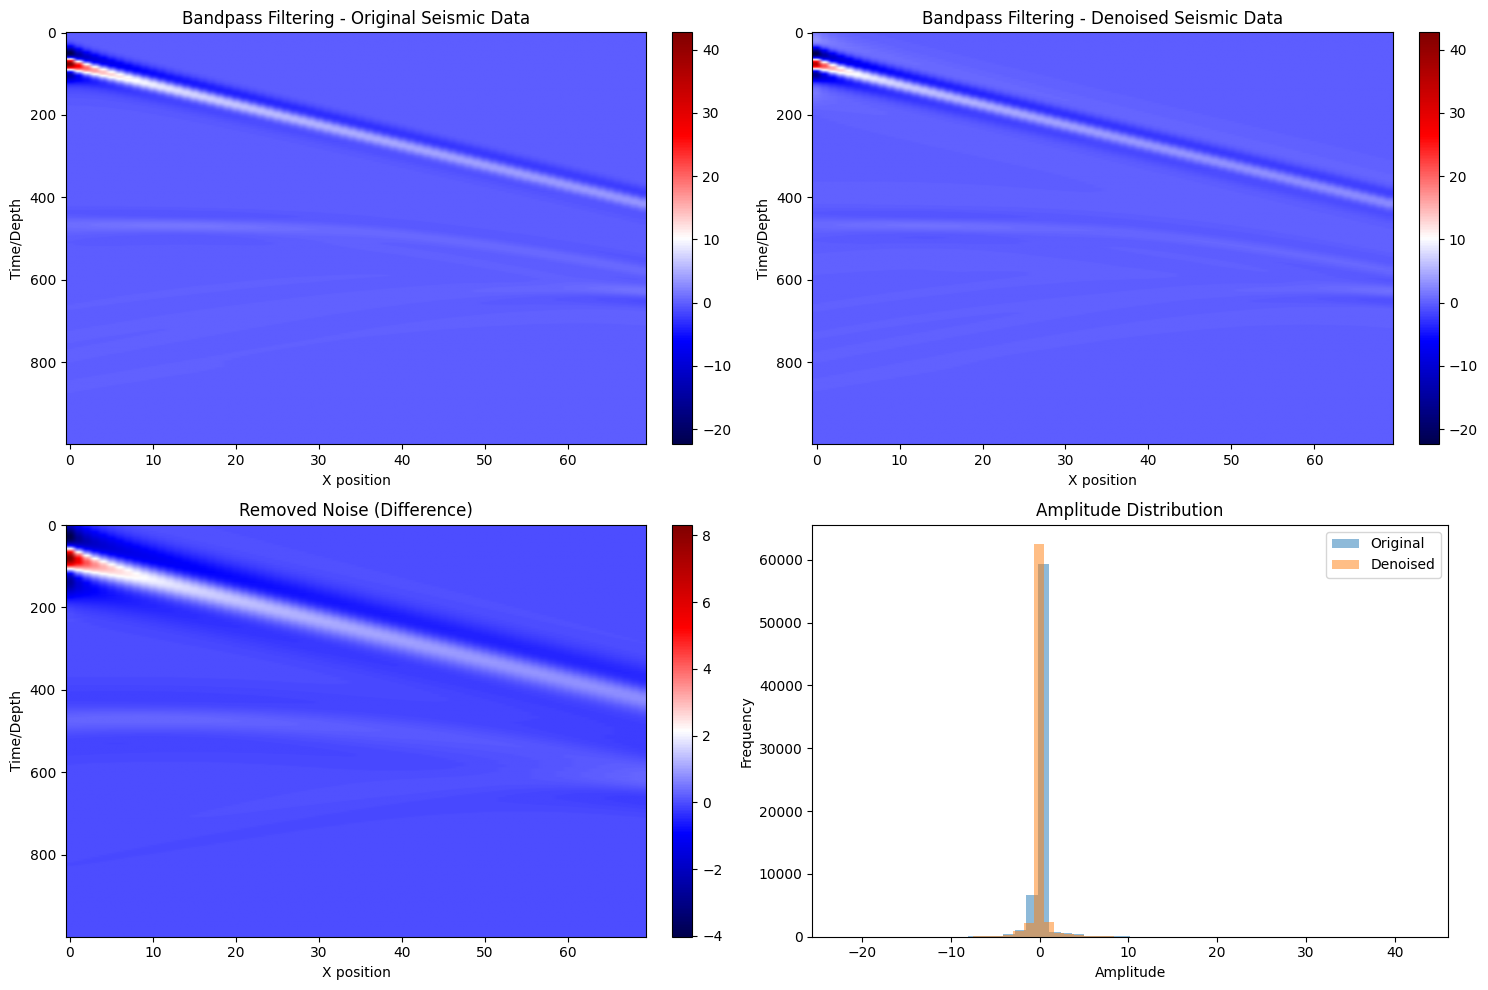

Noise removed: 42.66%
Estimated SNR improvement: inf dB


d:\Projects\geo_wave_inversion\.venv\lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [38]:
# Bandpass filtering with default parameters
bandpass_denoised = bandpass_filter_2d(original_seismic)
visualize_denoising(original_seismic, bandpass_denoised, title_prefix="Bandpass Filtering - ")

In [39]:
# Combined approach
# combined_denoised = denoise_seismic_data(original_seismic, method='both')
# visualize_denoising(original_seismic, combined_denoised, title_prefix="Combined Denoising - ")

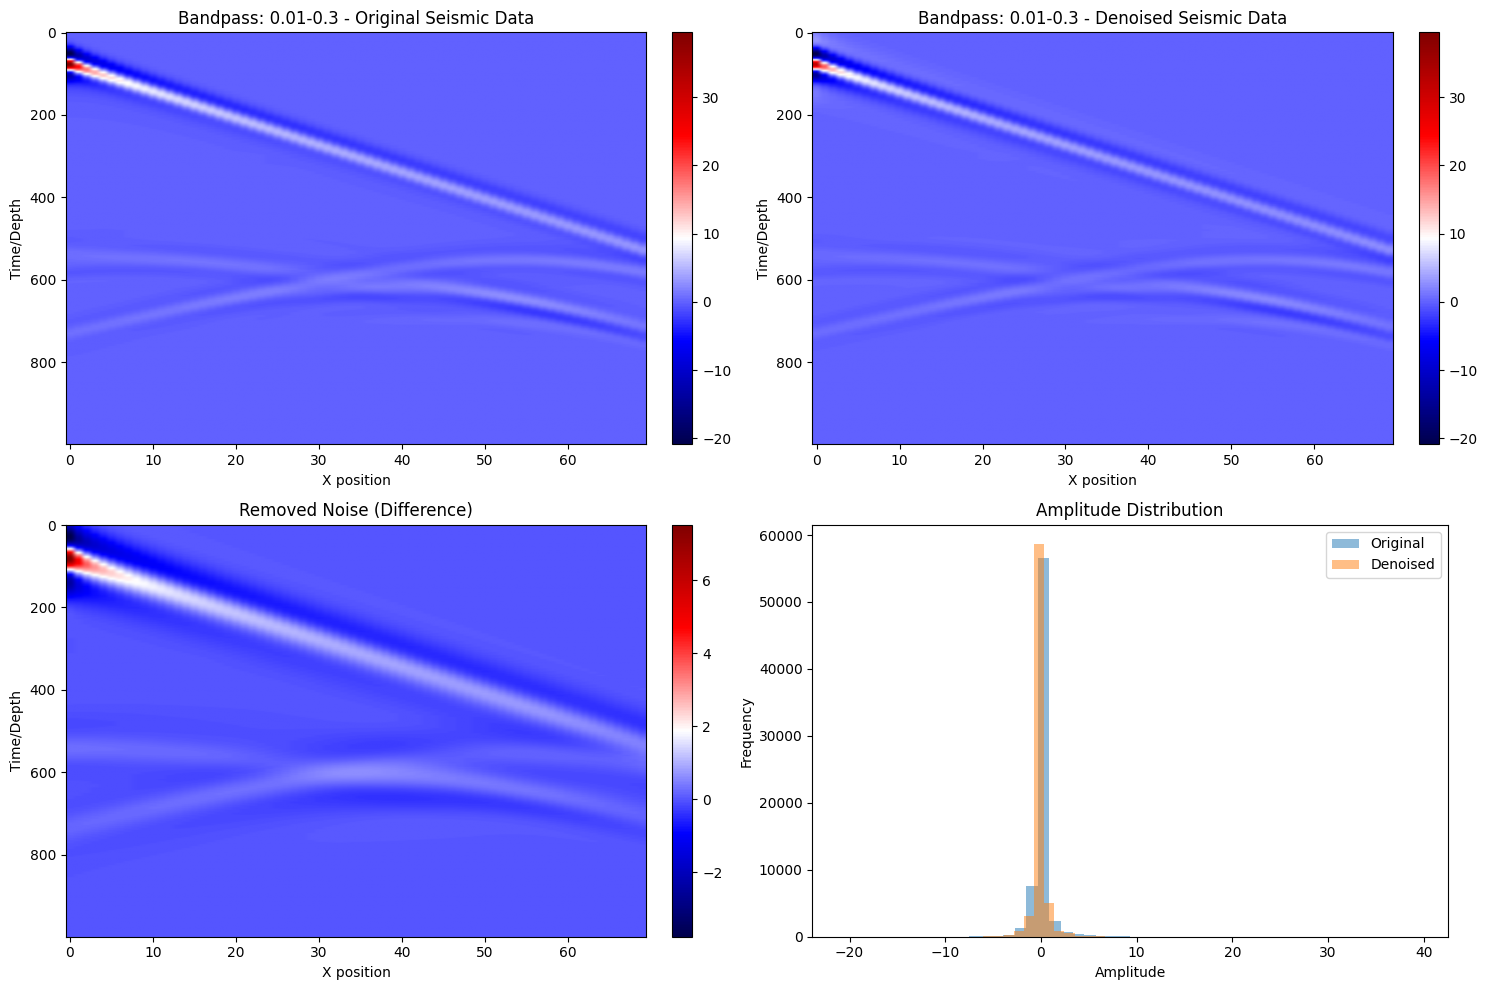

Noise removed: 38.56%
Estimated SNR improvement: inf dB


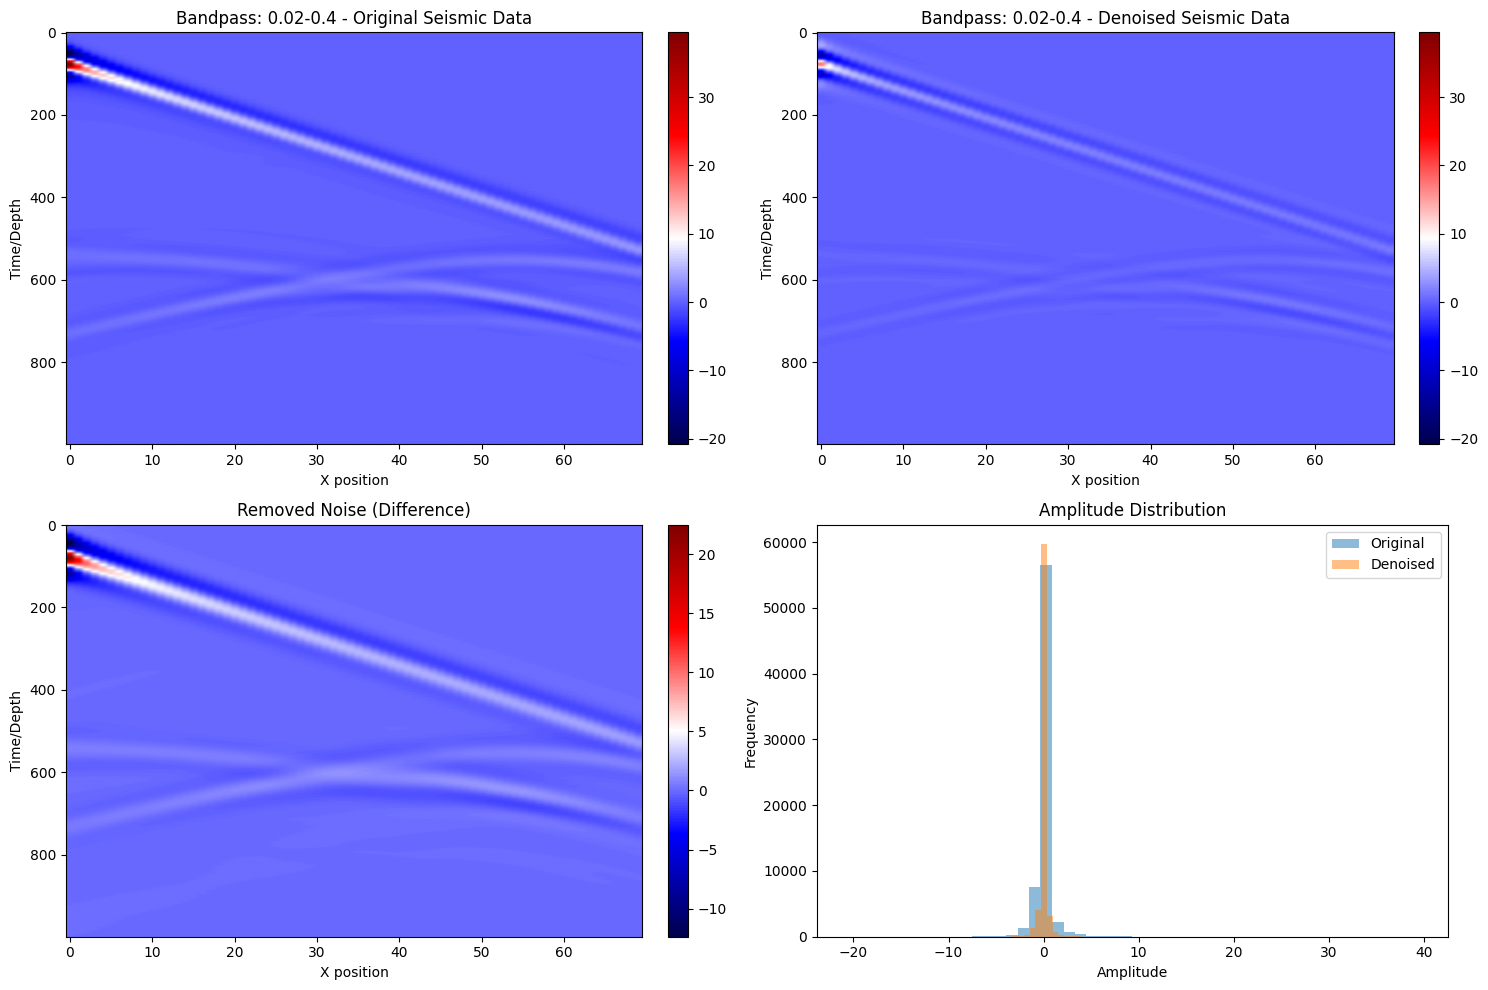

Noise removed: 76.50%
Estimated SNR improvement: inf dB


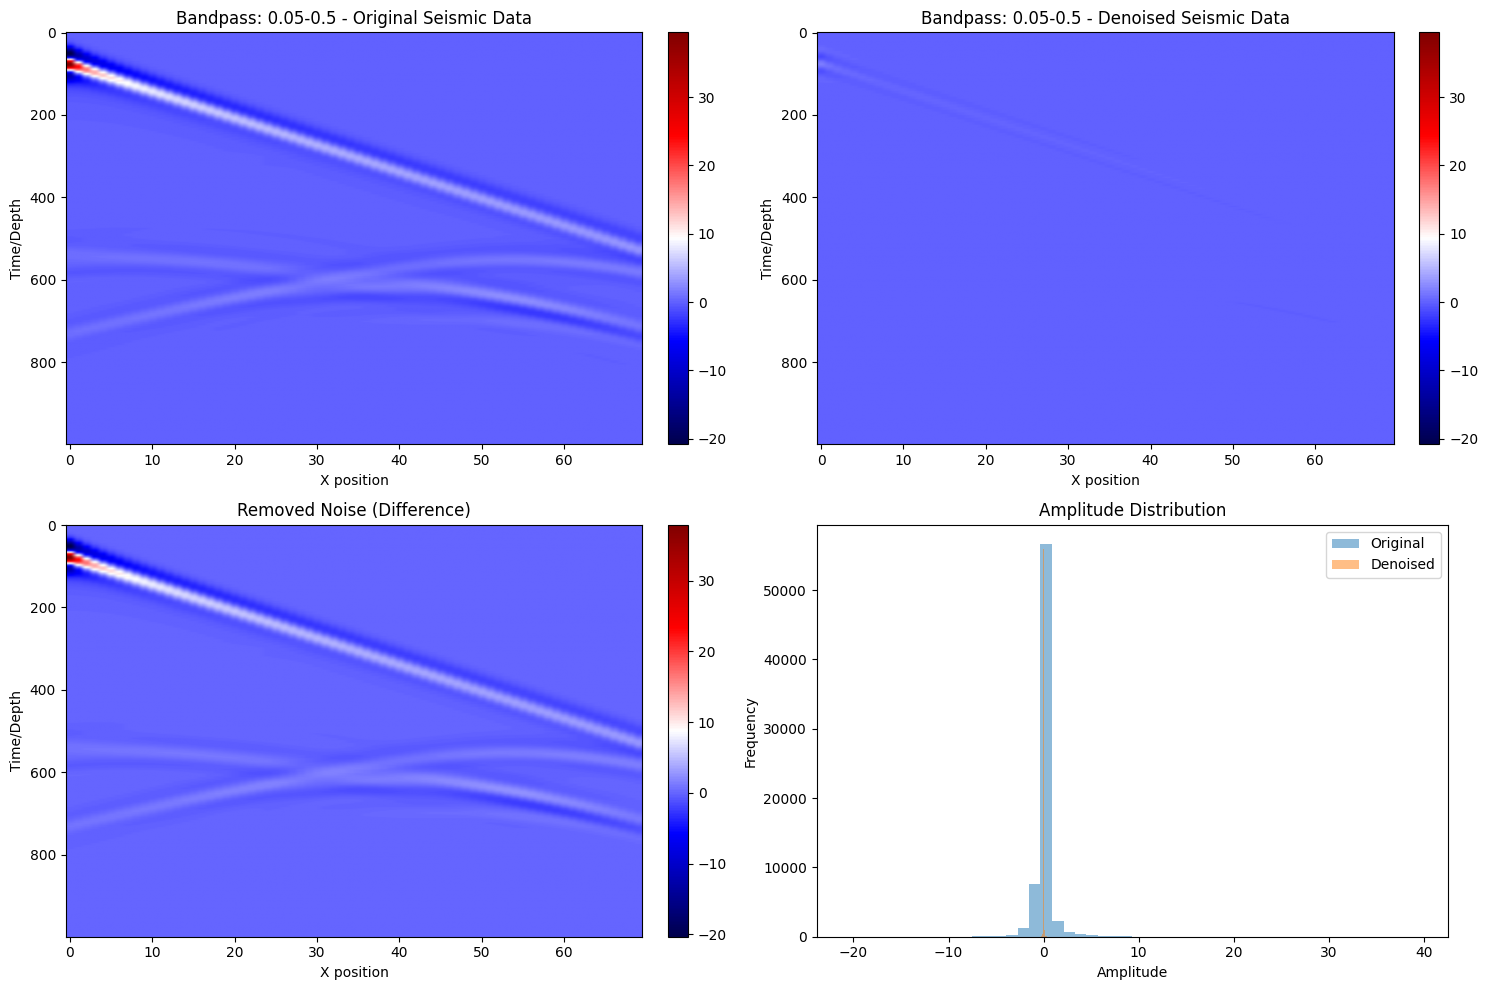

C:\Users\clark\AppData\Local\Temp\ipykernel_27324\4236737173.py:115: RuntimeWarning: invalid value encountered in scalar divide
  snr_before = 10 * np.log10(np.var(original) / np.var(difference))


Noise removed: 98.56%
Estimated SNR improvement: nan dB


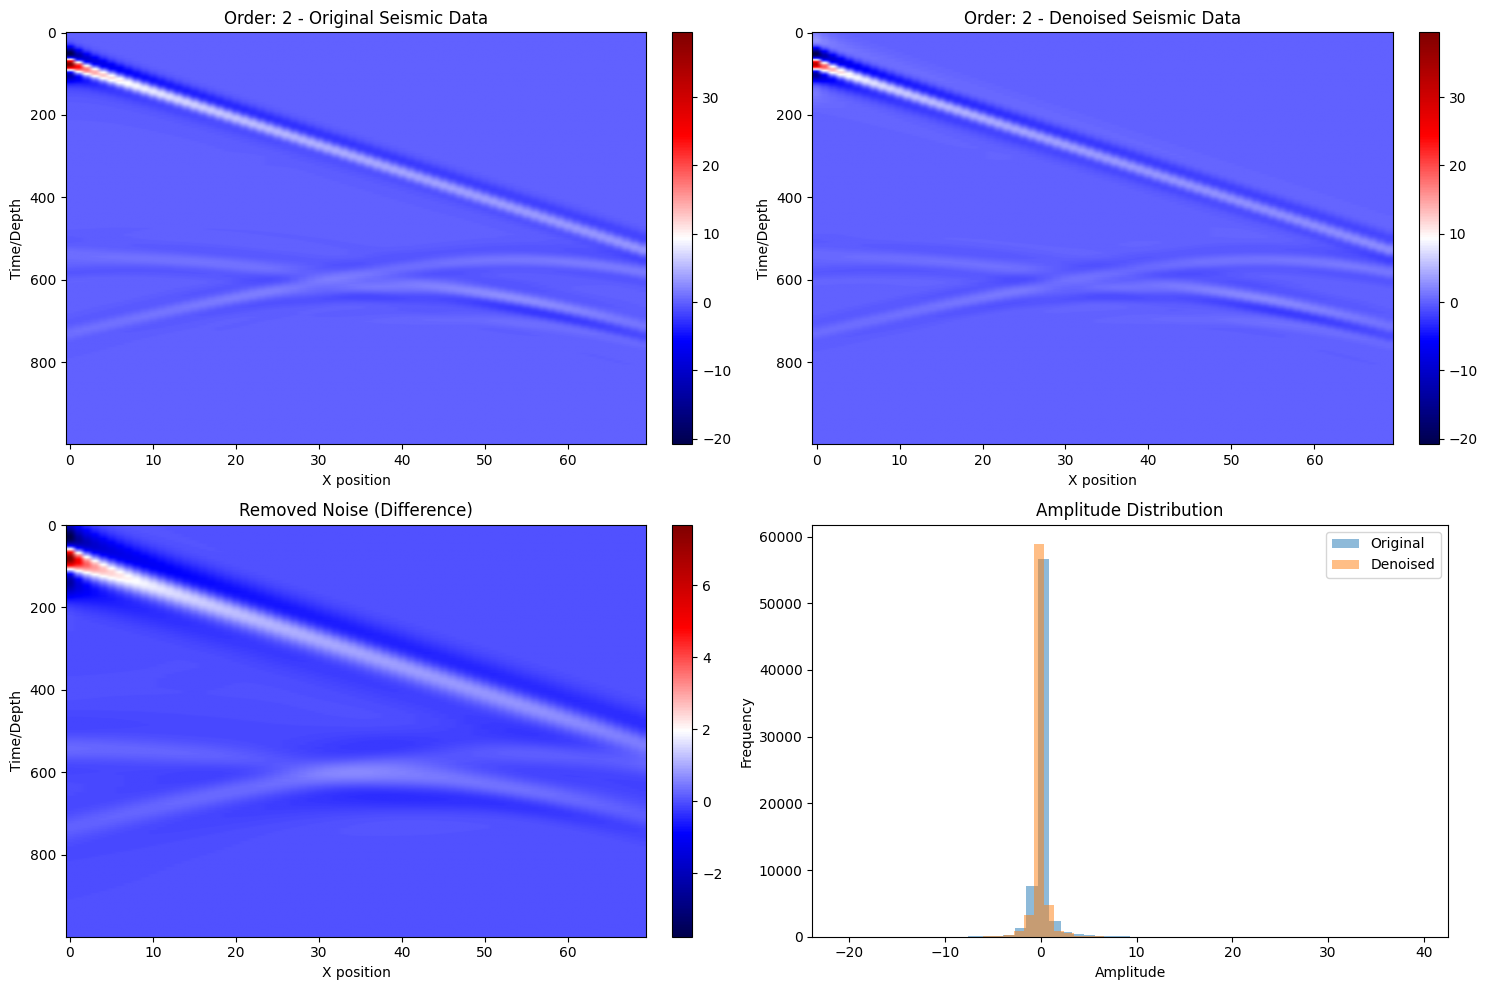

Noise removed: 38.56%
Estimated SNR improvement: inf dB


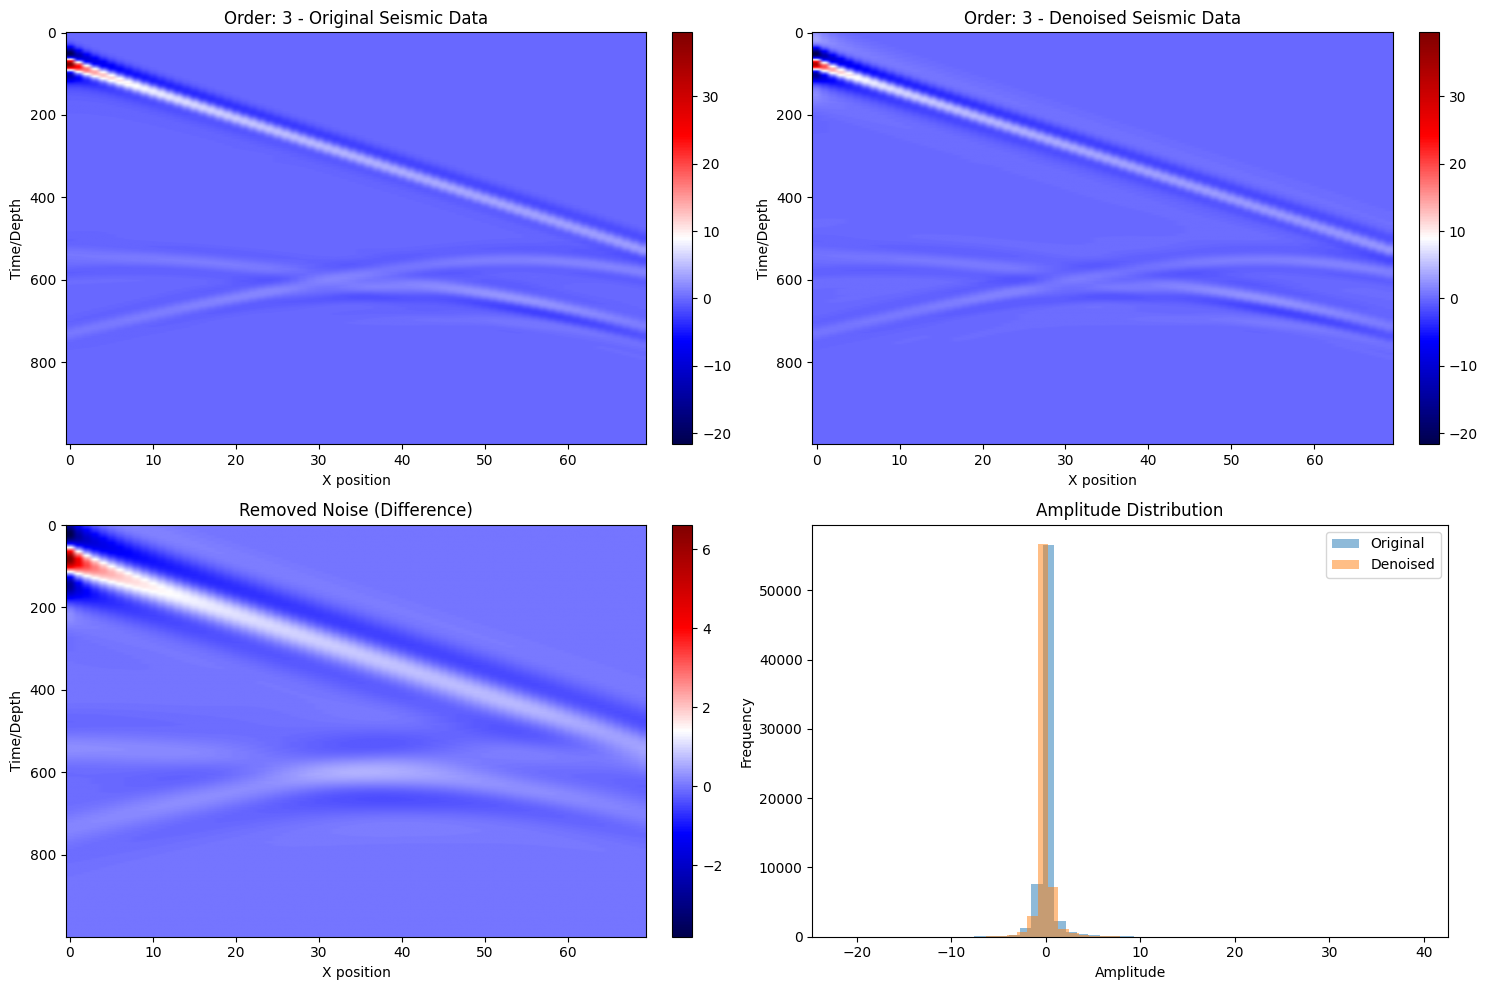

Noise removed: 40.47%
Estimated SNR improvement: inf dB


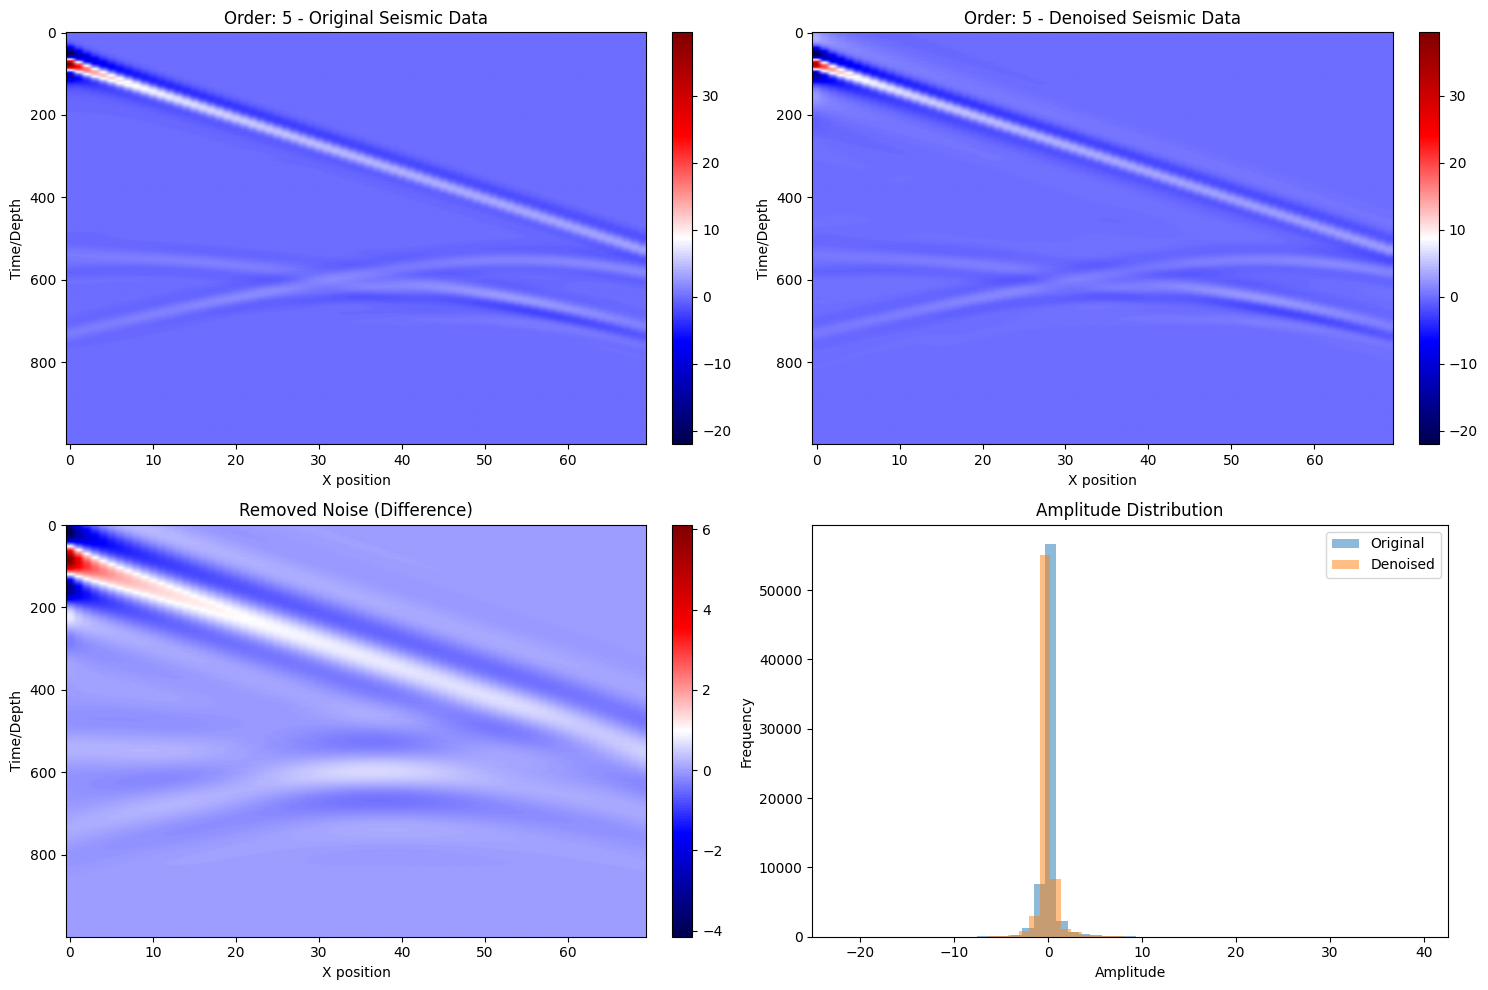

Noise removed: 44.88%
Estimated SNR improvement: inf dB


In [40]:
# Test different parameters to find optimal settings
test_denoising_parameters(input_data, method='bandpass')

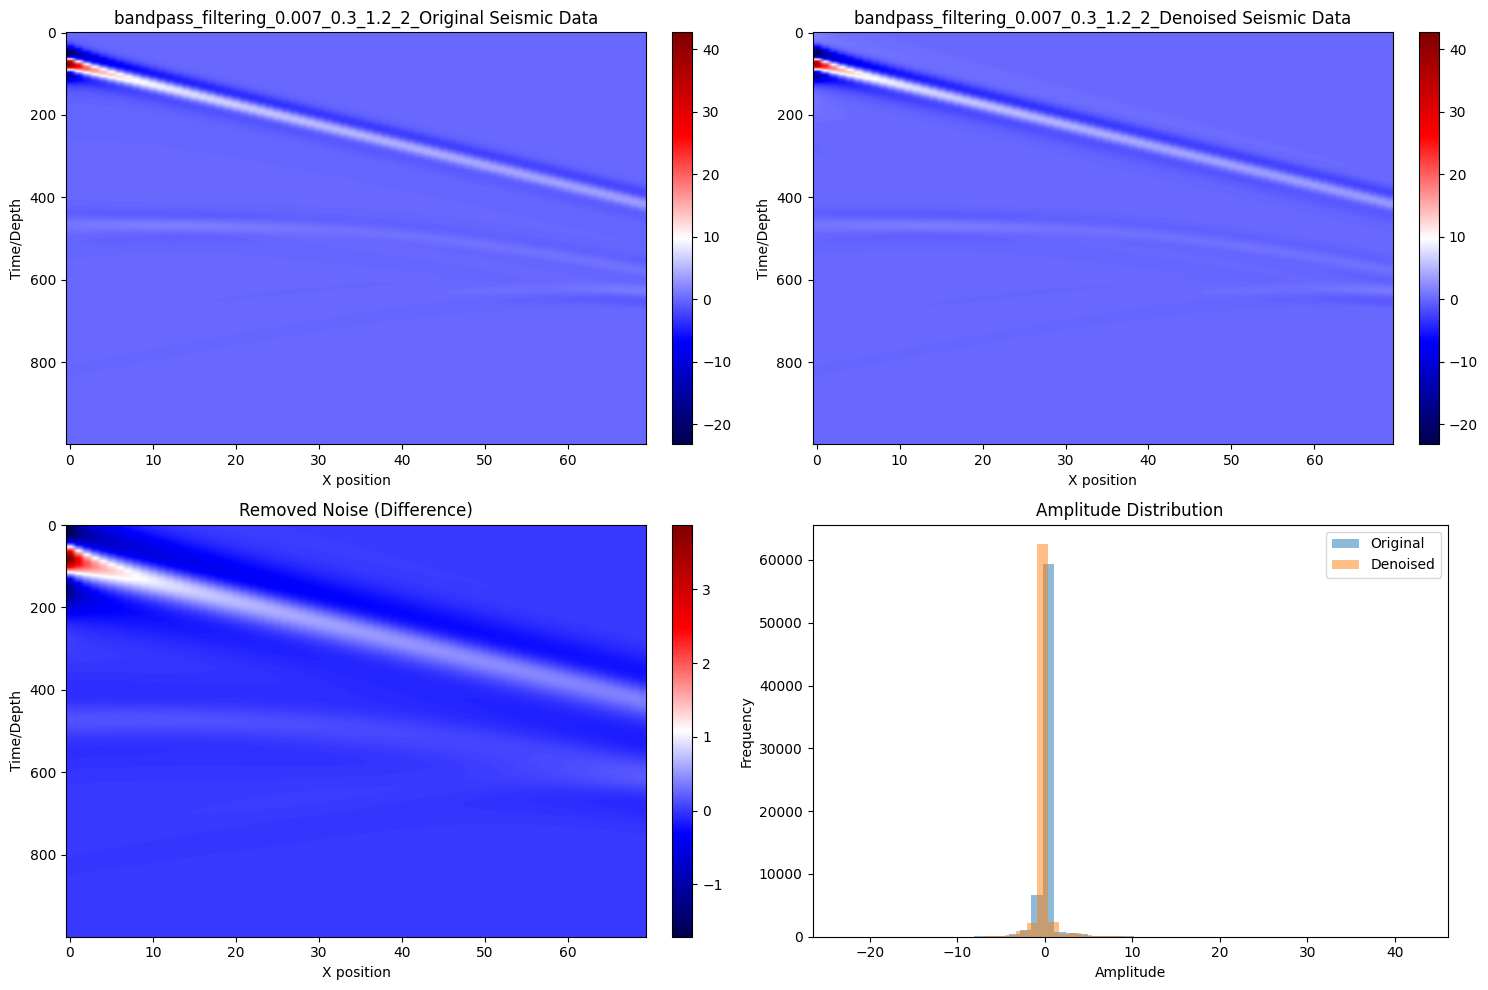

Noise removed: 26.75%
Estimated SNR improvement: inf dB


In [51]:
# Final Denoise settings
lowcut=0.007
highcut=0.3 
fs=1.2 
order=2

# Apply bandpass filtering with your recommended frequency range
bandpass_denoised = bandpass_filter_2d(original_seismic, lowcut, highcut, fs, order)
visualize_denoising(original_seismic, bandpass_denoised, title_prefix=f"bandpass_filtering_{lowcut}_{highcut}_{fs}_{order}_")

# Final Cleaning and Pre-Processing Implementation

## Load All Data

In [ ]:
class SeismicDataset(Dataset):
    def __init__(self, inputs_files, output_files, n_examples_per_file=500):
        assert len(inputs_files) == len(output_files)
        self.inputs_files = inputs_files
        self.output_files = output_files
        self.n_examples_per_file = n_examples_per_file

    def __len__(self):
        return len(self.inputs_files) * self.n_examples_per_file

    def __getitem__(self, idx):
        # Calculate file offset and sample offset within file
        file_idx = idx // self.n_examples_per_file
        sample_idx = idx % self.n_examples_per_file

        X = np.load(self.inputs_files[file_idx], mmap_mode='r')
        y = np.load(self.output_files[file_idx], mmap_mode='r')

        try:
            return X[sample_idx].copy(), y[sample_idx].copy()
        finally:
            del X, y


class TestDataset(Dataset):
    def __init__(self, test_files):
        self.test_files = test_files


    def __len__(self):
        return len(self.test_files)


    def __getitem__(self, i):
        test_file = self.test_files[i]

        return np.load(test_file), test_file.stem

In [ ]:
# Main seismic data loading function
def load_seismic_data(
                    data_paths,
                    config=None,
                    n_examples_per_file=500,
                    test_path=None
                ):

    # Default config
    if config is None:
        config = {
            "batch_size": 32,
            "valid_frac": 16,
            "train_frac": 1,
            "seed": 42,
            "num_workers": 4
        }
    
    # Set random seed for reproducibility
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(config["seed"])
    
    # Load all input and output files
    all_inputs, all_outputs = [], []
    for path in data_paths:
        inputs, outputs = get_train_files(path)
        all_inputs.extend(inputs)
        all_outputs.extend(outputs)
    
    print(f"Total number of input/output files: {len(all_inputs)}")
    
    # Split into validation and training sets
    valid_inputs = [all_inputs[i] for i in range(0, len(all_inputs), config["valid_frac"])]
    train_inputs = [f for f in all_inputs if f not in valid_inputs]
    
    # Apply train_frac if > 1
    if config["train_frac"] > 1:
        train_inputs = [train_inputs[i] for i in range(0, len(train_inputs), config["train_frac"])]
    
    print(f"Number of train files: {len(train_inputs)}")
    print(f"Number of valid files: {len(valid_inputs)}")
    
    # Get corresponding output files
    train_outputs = [map_seismic_to_velocity_path(f) for f in train_inputs]
    valid_outputs = [map_seismic_to_velocity_path(f) for f in valid_inputs]
    
    # Create datasets and dataloaders
    train_dataset = SeismicDataset(train_inputs, train_outputs, n_examples_per_file)
    train_loader = DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        pin_memory=False,
        drop_last=True,
        num_workers=config["num_workers"],
        persistent_workers=True,
    )
    
    valid_dataset = SeismicDataset(valid_inputs, valid_outputs, n_examples_per_file)
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=4*config["batch_size"],
        shuffle=False,
        pin_memory=False,
        drop_last=False,
        num_workers=config["num_workers"],
        persistent_workers=True,
    )
    
    # Handle test data if provided
    test_loader, test_dataset, test_files = None, None, None
    if test_path:
        # Handle if test_path is a list with a single element
        if isinstance(test_path, list):
            if len(test_path) > 0:
                test_path = test_path[0]
            else:
                test_path = None
        
        if test_path:
            # Load test files directly using glob pattern
            test_files = list(Path(test_path).glob("*.npy"))
            print(f"Number of test files: {len(test_files)}")
            
            # Create x column names for feature engineering
            x_cols = [f"x_{i}" for i in range(1, 70, 2)]
            fieldnames = ["oid_ypos"] + x_cols
            
            # Create test dataset and dataloader
            test_dataset = TestDataset(test_files)
            test_loader = DataLoader(
                test_dataset,
                batch_size=4*config["batch_size"],
                num_workers=config["num_workers"],
                pin_memory=False,
            )
    
    # Return individual components
    return (
        train_loader,
        valid_loader,
        train_dataset,
        valid_dataset,
        train_inputs,
        train_outputs,
        valid_inputs,
        valid_outputs,
        test_loader,
        test_dataset
    )

In [ ]:
# Data paths
data_paths = [
            "/kaggle/input/waveform-inversion/train_samples", 
            #"/kaggle/input/open-wfi-1/openfwi_float16_1", 
            #"/kaggle/input/open-wfi-2/openfwi_float16_2"
             ]
test_path = [
            "/kaggle/input/waveform-inversion/test",
            # "/kaggle/input/open-wfi-test/test"            
]

In [ ]:
# Custom config
custom_config = {
    "batch_size": 32,
    "valid_frac": 16,
    "train_frac": 1,  # Change to 2 to reduce dataset
    "seed": 42,
    "num_workers": 4
}

# Load all datasets with individual return values
(
    train_loader,
    valid_loader,
    train_dataset,
    valid_dataset,
    train_inputs,
    train_outputs,
    valid_inputs,
    valid_outputs,
    test_loader,
    test_dataset
) = load_seismic_data(
    data_paths=data_paths,
    config=custom_config,
    test_path=test_path
)

In [ ]:
# Check test files
if train_dataset:
    print(f"Train files count: {len(train_dataset)}")
    print(f"First train file: {train_dataset[0]}")

## Denoise Input Data

In [ ]:
# Helper functions 
def butter_bandpass(lowcut, highcut, fs, order=2):
    """Design a Butterworth bandpass filter."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', output='ba')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    """Apply a Butterworth bandpass filter to a 1D signal."""
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

def denoise_seismic_with_bandpass(data, lowcut=0.01, highcut=0.3, fs=1.2, order=2):
    """
    Apply Butterworth bandpass filter to seismic data.
    Handles 2D, 3D, or 4D data.
    Inner tqdm progress bars are disabled to reduce verbosity.
    """
    original_shape = data.shape
    
    if len(original_shape) == 4: # 4D data (e.g., batch, channels, height, width)
        denoised_data = np.zeros_like(data)
        # Iterate through the first dimension (samples in batch)
        for s_idx in tqdm(range(original_shape[0]), desc="Processing samples in batch", leave=False, disable=True):
            for c_idx in range(original_shape[1]): # Channels
                denoised_data[s_idx, c_idx] = denoise_seismic_with_bandpass(
                    data[s_idx, c_idx], lowcut, highcut, fs, order
                )
        return denoised_data
    
    elif len(original_shape) == 3: # 3D data (e.g., batch/channels, height, width)
        denoised_data = np.zeros_like(data)
        # Iterate through the first dimension (channels or slices)
        for c_idx in tqdm(range(original_shape[0]), desc="Processing channels/slices", leave=False, disable=True):
            denoised_data[c_idx] = denoise_seismic_with_bandpass(
                data[c_idx], lowcut, highcut, fs, order
            )
        return denoised_data
    
    elif len(original_shape) == 2: # 2D data (height, width) - filter per trace
        denoised_data = np.zeros_like(data)
        for i in range(data.shape[1]): # Iterate over traces (width)
            trace = data[:, i]
            # filtfilt requirement: signal length > 3 * filter order
            if len(trace) > order * 3:
                 denoised_data[:, i] = butter_bandpass_filter(trace, lowcut, highcut, fs, order)
            else:
                # To avoid verbose output, this warning is kept as a comment.
                # print(f"Warning: Trace length ({len(trace)}) for trace {i} too short for filter order ({order}). Copying original trace.")
                denoised_data[:, i] = trace
        return denoised_data
    
    else:
        raise ValueError(f"Unsupported data shape: {original_shape}. Expected 2D, 3D, or 4D.")

# Revised memory-efficient function with reduced print output
def denoise_training_dataset_memory_efficient(train_loader, lowcut=0.01, highcut=0.3, fs=1.2, order=2):
    denoised_inputs_list = []
    targets_list = []

    print("Starting memory-efficient denoising process...")
    
    try:
        total_batches = len(train_loader)
    except TypeError:
        total_batches = None 

    overall_start_time = time.time()

    # This is the main progress bar the user will see, updating per batch
    for inputs_batch, targets_batch in tqdm(train_loader, desc="Denoising batches", total=total_batches, unit="batch"):
        inputs_batch_np = inputs_batch.numpy() 
        
        denoised_batch = denoise_seismic_with_bandpass(
            inputs_batch_np, lowcut=lowcut, highcut=highcut, fs=fs, order=order
        )

        denoised_inputs_list.append(denoised_batch)
        targets_list.append(targets_batch.numpy()) 
    
    overall_elapsed_time = time.time() - overall_start_time
    # Adding a newline to ensure this print is on a new line after tqdm finishes
    print(f"\nAll batches processed in {overall_elapsed_time:.2f} seconds.")

    print("Concatenating denoised batches and targets...")
    concatenation_start_time = time.time()
    
    final_denoised_inputs = np.concatenate(denoised_inputs_list, axis=0)
    final_targets = np.concatenate(targets_list, axis=0)
    
    concatenation_elapsed_time = time.time() - concatenation_start_time
    print(f"Concatenation completed in {concatenation_elapsed_time:.2f} seconds.")
    
    return final_denoised_inputs, final_targets

# Apply denoising to training data using the memory-efficient function
# print("Starting denoising process with revised function...")
#denoised_inputs, targets = denoise_training_dataset_memory_efficient(
#     train_loader,
#     lowcut=0.01,
#     highcut=0.3,
#     fs=1.2,
#     order=2
# )

# Check shapes
#print("\n--- Final Shapes ---")
#print("Denoised inputs shape:", denoised_inputs.shape)
#print("Targets shape:", targets.shape)

## Normalization

In [ ]:
def normalize_trace_robust(trace, lower_quantile=0.05, upper_quantile=0.95, eps=1e-8):
    """
    Apply robust quantile normalization to a single trace.
    """
    # Skip normalization if trace is all zeros or constant
    if np.all(trace == trace[0]):
        return trace
    
    # Calculate robust quantiles
    q_low = np.quantile(trace, lower_quantile)
    q_high = np.quantile(trace, upper_quantile)
    
    # Handle case where quantiles are very close
    if np.abs(q_high - q_low) < eps:
        median = np.median(trace)
        mad = np.median(np.abs(trace - median))
        if mad < eps:
            return np.zeros_like(trace)
        return (trace - median) / (mad * 1.4826 + eps)
    
    # Perform robust min-max scaling to approximately [-1, 1]
    normalized_trace = 2 * ((trace - q_low) / (q_high - q_low + eps)) - 1
    
    # Clip outliers that fall outside the quantile range
    normalized_trace = np.clip(normalized_trace, -1, 1)
    
    return normalized_trace

def normalize_denoised_data(denoised_inputs, targets, lower_quantile=0.05, upper_quantile=0.95):
    """
    Apply robust quantile normalization to already denoised seismic data.
    
    Parameters:
    -----------
    denoised_inputs : ndarray
        Already denoised input data with shape (batch, channels, time, traces)
    targets : ndarray
        Target data with shape (batch, channels, height, width)
    lower_quantile : float
        Lower quantile value (default: 0.05)
    upper_quantile : float
        Upper quantile value (default: 0.95)
        
    Returns:
    --------
    tuple
        (normalized_inputs, targets) without modifying targets
    """
    print("Starting normalization of denoised data...")
    start_time = time.time()
    
    # Get shape information
    batch_size, n_channels, time_steps, n_traces = denoised_inputs.shape
    normalized_inputs = np.zeros_like(denoised_inputs)
    
    # Progress tracking
    total_samples = batch_size * n_channels * n_traces
    pbar = tqdm(total=total_samples, desc="Normalizing traces")
    
    # Apply normalization per trace
    for b in range(batch_size):
        for c in range(n_channels):
            for t in range(n_traces):
                normalized_inputs[b, c, :, t] = normalize_trace_robust(
                    denoised_inputs[b, c, :, t],
                    lower_quantile,
                    upper_quantile
                )
                pbar.update(1)
    
    pbar.close()
    
    elapsed_time = time.time() - start_time
    print(f"Normalization completed in {elapsed_time:.2f} seconds.")
    
    # Print final shapes
    print("\n--- Final Shapes ---")
    print("Normalized inputs shape:", normalized_inputs.shape)
    print("Targets shape:", targets.shape)
    
    return normalized_inputs, targets


In [ ]:
# Usage
# normalized_inputs, targets = normalize_denoised_data(denoised_inputs, targets)

# Check shapes
# print("\n--- Final Shapes ---")
# print("Normalized inputs shape:", normalized_inputs.shape)
# print("Targets shape:", targets.shape)

In [ ]:
# Get current process
process = psutil.Process(os.getpid())

# Get memory info in MB
memory_info = process.memory_info()
memory_usage = memory_info.rss / 1024 / 1024  # Convert bytes to MB
print(f"Memory usage: {memory_usage:.2f} MB")

## Channel-Adaptive Processing

In [ ]:
# processing functions
def histogram_equalization_seismic(normalized_inputs, targets, n_bins=1000, clip_percentile=99.5):
    """
    Apply histogram equalization to normalized seismic data to improve
    amplitude distribution and enhance subtle features.
    
    Parameters:
    -----------
    normalized_inputs : ndarray
        Already normalized input data with shape (batch, channels, time, traces)
    targets : ndarray
        Target data, passed through unchanged
    n_bins : int
        Number of bins for histogram equalization
    clip_percentile : float
        Percentile for clipping to avoid extreme outliers (0-100)
        
    Returns:
    --------
    tuple
        (equalized_inputs, targets) without modifying targets
    """
    print("Starting histogram equalization for seismic data...")
    start_time = time.time()
    
    # Get shape information
    batch_size, n_channels, time_steps, n_traces = normalized_inputs.shape
    equalized_inputs = np.zeros_like(normalized_inputs)
    
    # Progress tracking
    pbar = tqdm(total=batch_size * n_channels, desc="Histogram equalization")
    
    for b in range(batch_size):
        for c in range(n_channels):
            # Process each channel separately
            channel_data = normalized_inputs[b, c]
            
            # Find non-zero values (signal)
            non_zero_mask = np.abs(channel_data) > 1e-6
            if np.sum(non_zero_mask) > 100:  # Skip if too few non-zero values
                # Get data values for histogram computation
                data_values = channel_data[non_zero_mask]
                
                # Clip extreme outliers
                clip_value = np.percentile(np.abs(data_values), clip_percentile)
                clipped_data = np.clip(channel_data, -clip_value, clip_value)
                
                # Create histogram and cumulative distribution
                hist, bin_edges = np.histogram(clipped_data, bins=n_bins, range=(-clip_value, clip_value))
                cdf = hist.cumsum() / hist.sum()
                
                # Create mapping function (histogram equalization)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                equalized_data = np.interp(clipped_data.flatten(), bin_centers, 2 * cdf - 1).reshape(clipped_data.shape)
                
                # Apply a mild Gaussian smoothing to avoid artifacts
                equalized_data = ndimage.gaussian_filter(equalized_data, sigma=0.5)
                
                # Clip to normalized range
                equalized_inputs[b, c] = np.clip(equalized_data, -1, 1)
            else:
                # Copy original data if not enough non-zero values
                equalized_inputs[b, c] = normalized_inputs[b, c]
            
            pbar.update(1)
    
    pbar.close()
    
    elapsed_time = time.time() - start_time
    print(f"Histogram equalization completed in {elapsed_time:.2f} seconds.")
    
    return equalized_inputs, targets

def adaptive_agc(normalized_inputs, targets, window_sizes=[50, 100, 200], blend_weights=[0.2, 0.3, 0.5]):
    """
    Apply multi-scale Automatic Gain Control to normalized seismic data.
    This approach uses multiple window sizes and blends the results to
    enhance features at different scales.
    
    Parameters:
    -----------
    normalized_inputs : ndarray
        Already normalized input data with shape (batch, channels, time, traces)
    targets : ndarray
        Target data, passed through unchanged
    window_sizes : list
        List of window sizes for AGC (in samples)
    blend_weights : list
        List of weights for blending AGC results (must sum to 1)
        
    Returns:
    --------
    tuple
        (balanced_inputs, targets) without modifying targets
    """
    print("Starting multi-scale AGC amplitude balancing...")
    start_time = time.time()
    
    # Get shape information
    batch_size, n_channels, time_steps, n_traces = normalized_inputs.shape
    balanced_inputs = np.zeros_like(normalized_inputs)
    
    # Validate weights
    if len(window_sizes) != len(blend_weights):
        raise ValueError("window_sizes and blend_weights must have the same length")
    if abs(sum(blend_weights) - 1.0) > 1e-6:
        print("Warning: blend_weights don't sum to 1. Normalizing...")
        blend_weights = [w / sum(blend_weights) for w in blend_weights]
    
    # Progress tracking
    pbar = tqdm(total=batch_size * n_channels * n_traces, desc="Multi-scale AGC")
    
    for b in range(batch_size):
        for c in range(n_channels):
            for t in range(n_traces):
                trace = normalized_inputs[b, c, :, t]
                
                # Skip processing if trace is mostly zeros
                if np.sum(np.abs(trace)) < 1e-6:
                    balanced_inputs[b, c, :, t] = trace
                    pbar.update(1)
                    continue
                
                # Initialize with zeros
                blended_trace = np.zeros_like(trace)
                
                # Apply AGC at multiple scales and blend
                for i, window_size in enumerate(window_sizes):
                    half_win = window_size // 2
                    agc_trace = np.zeros_like(trace)
                    
                    # Calculate the sliding window AGC
                    for i_sample in range(time_steps):
                        # Define window bounds
                        win_start = max(0, i_sample - half_win)
                        win_end = min(time_steps, i_sample + half_win + 1)
                        
                        # Calculate RMS in window
                        window_rms = np.sqrt(np.mean(trace[win_start:win_end]**2) + 1e-10)
                        
                        # Apply AGC gain
                        agc_trace[i_sample] = trace[i_sample] / window_rms
                    
                    # Blend with appropriate weight
                    blended_trace += blend_weights[i] * agc_trace
                
                # Ensure we stay in the normalized range
                max_abs = np.max(np.abs(blended_trace))
                if max_abs > 1.0:
                    blended_trace /= max_abs
                
                balanced_inputs[b, c, :, t] = blended_trace
                pbar.update(1)
    
    pbar.close()
    
    # Apply a final mild smoothing to reduce artifacts
    for b in range(batch_size):
        for c in range(n_channels):
            balanced_inputs[b, c] = ndimage.gaussian_filter(balanced_inputs[b, c], sigma=0.5)
    
    # Final clipping to ensure staying in [-1,1] range
    balanced_inputs = np.clip(balanced_inputs, -1.0, 1.0)
    
    elapsed_time = time.time() - start_time
    print(f"Multi-scale AGC completed in {elapsed_time:.2f} seconds.")
    
    return balanced_inputs, targets

def amplitude_distribution_matching(normalized_inputs, targets, n_bins=1000, smoothing_sigma=0.5):
    """
    Match the amplitude distribution of seismic data to better represent
    the discrete layering in velocity models. This approach is tailored
    for seismic inversion tasks where the target models have multi-modal 
    distributions.
    
    Parameters:
    -----------
    normalized_inputs : ndarray
        Already normalized input data with shape (batch, channels, time, traces)
    targets : ndarray
        Target data with shape (batch, channels, height, width)
    n_bins : int
        Number of bins for histogram processing
    smoothing_sigma : float
        Sigma for Gaussian smoothing to reduce artifacts
        
    Returns:
    --------
    tuple
        (matched_inputs, targets) without modifying targets
    """
    print("Starting amplitude distribution matching...")
    start_time = time.time()
    
    # Get shape information
    batch_size, n_channels, time_steps, n_traces = normalized_inputs.shape
    matched_inputs = np.copy(normalized_inputs)
    
    # Channel-wise processing
    for c in range(n_channels):
        print(f"Processing channel {c}...")
        
        # Get all data for this channel across all batches
        channel_data = normalized_inputs[:, c].reshape(-1)
        
        # Create more contrast in the amplitude distribution
        # Find non-zero values (the main signal)
        non_zero_mask = np.abs(channel_data) > 0.01
        if np.sum(non_zero_mask) > 1000:  # Skip if too few significant values
            channel_values = channel_data[non_zero_mask]
            
            # Calculate contrast enhancement function
            # This will expand the dynamic range of weak reflection data
            alpha = 0.4  # Controls contrast enhancement
            enhancement = np.sign(channel_values) * (np.abs(channel_values) ** alpha)
            
            # Create mapping for all values
            sorted_orig = np.sort(channel_values)
            sorted_enhanced = np.sort(enhancement)
            
            # Apply mapping to all data in this channel
            for b in range(batch_size):
                for t in range(n_traces):
                    trace = matched_inputs[b, c, :, t]
                    # Apply the mapping
                    mapped_trace = np.interp(trace, sorted_orig, sorted_enhanced)
                    # Apply smoothing to reduce artifacts
                    if smoothing_sigma > 0:
                        mapped_trace = ndimage.gaussian_filter1d(mapped_trace, sigma=smoothing_sigma)
                    # Store the result
                    matched_inputs[b, c, :, t] = mapped_trace
    
    # Final normalization to ensure staying in [-1,1] range
    for b in range(batch_size):
        for c in range(n_channels):
            max_abs = np.max(np.abs(matched_inputs[b, c]))
            if max_abs > 1.0:
                matched_inputs[b, c] /= max_abs
    
    # Apply final clipping
    matched_inputs = np.clip(matched_inputs, -1.0, 1.0)
    
    elapsed_time = time.time() - start_time
    print(f"Amplitude distribution matching completed in {elapsed_time:.2f} seconds.")
    
    # Print final shapes
    print("\n--- Final Shapes ---")
    print("Matched inputs shape:", matched_inputs.shape)
    print("Targets shape:", targets.shape)
    
    return matched_inputs, targets

def channel_adaptive_processing(normalized_inputs, targets):
    """
    Apply different processing strategies for different channels
    based on their characteristics (observed in the histograms).
    
    Parameters:
    -----------
    normalized_inputs : ndarray
        Already normalized input data with shape (batch, channels, time, traces)
    targets : ndarray
        Target data
        
    Returns:
    --------
    tuple
        (processed_inputs, targets) without modifying targets
    """
    print("Starting channel-adaptive processing...")
    start_time = time.time()
    
    # Get shape information
    batch_size, n_channels, time_steps, n_traces = normalized_inputs.shape
    processed_inputs = np.copy(normalized_inputs)
    
    # Create a separate processing pipeline for different channel types
    # Channels 0 and 4 (more linear features)
    linear_channels = [0, 4]
    # Channels 1, 2, 3 (V-shaped reflections)
    reflection_channels = [1, 2, 3]
    
    # Process linear channels (0, 4) with multi-scale AGC
    for c in linear_channels:
        if c < n_channels:  # Make sure channel exists
            print(f"Processing linear channel {c} with multi-scale AGC...")
            # Extract just this channel for processing
            channel_data = processed_inputs[:, c:c+1]
            targets_copy = targets  # Unchanged
            
            # Apply multi-scale AGC
            window_sizes = [30, 100, 200]  # Smaller windows to enhance linear features
            blend_weights = [0.3, 0.4, 0.3]
            processed_channel, _ = adaptive_agc(
                channel_data, 
                targets_copy,
                window_sizes=window_sizes,
                blend_weights=blend_weights
            )
            
            # Put processed data back
            processed_inputs[:, c:c+1] = processed_channel
    
    # Process reflection channels (1, 2, 3) with distribution matching
    for c in reflection_channels:
        if c < n_channels:  # Make sure channel exists
            print(f"Processing reflection channel {c} with distribution matching...")
            # Extract just this channel for processing
            channel_data = processed_inputs[:, c:c+1]
            targets_copy = targets  # Unchanged
            
            # Apply amplitude distribution matching
            processed_channel, _ = amplitude_distribution_matching(
                channel_data,
                targets_copy,
                n_bins=1000,
                smoothing_sigma=0.5
            )
            
            # Put processed data back
            processed_inputs[:, c:c+1] = processed_channel
    
    elapsed_time = time.time() - start_time
    print(f"Channel-adaptive processing completed in {elapsed_time:.2f} seconds.")
    
    # Print final shapes
    print("\n--- Final Shapes ---")
    print("Processed inputs shape:", processed_inputs.shape)
    print("Targets shape:", targets.shape)
    
    return processed_inputs, targets

In [ ]:
# Apply the channel-adaptive processing (which uses the appropriate 
# technique for each channel)
# balanced_inputs, targets = channel_adaptive_processing(normalized_inputs, targets)

In [ ]:
# Add normalization
# Add data balancing
# The histograms (Image 7) show imbalanced amplitude distributions, which could affect model training
# Extract time-frequency features
# Extract the texture desriptors
# Extract Reflector Detection and Attributes
# Extract cross-channel features
# Incorporate velocity model as features